### Thermal wind balance transport estimation
Based on salinity and temperature difference, see Sohail et al. 2024

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import glob
import os

In [2]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [3]:
%matplotlib inline

In [4]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [5]:
session=cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [ ]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '01:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

In [7]:
import dask.config
from dask.distributed import Client,LocalCluster


c = Client()


In [8]:
c

<Client: 'tcp://127.0.0.1:44151' processes=7 threads=28, memory=126.00 GiB>

In [9]:
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yt_ocean = slice(-79,-60)).chunk({ 'yt_ocean':250, 'xt_ocean':1200})
ht

<xarray.DataArray 'ht' (yt_ocean: 440, xt_ocean: 3600)> Size: 6MB
dask.array<rechunk-merge, shape=(440, 3600), dtype=float32, chunksize=(250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [10]:
# location limits of dataset - choosing slice near totten
#lon_lim = slice(-270, -230) #slice(30, 45)#
lat_lim = slice(-79, -60) #slice(-70, -65)

ht_region = ht.sel( yt_ocean = lat_lim)

In [11]:
exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_wthmp


In [12]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
flex_period = slice(start_time_mw , end_time_mw)

In [13]:
mask_1000_1500 = xr.where((ht < 1500) & (ht > 1000), True, False) 
mask_500_1000 = xr.where((ht < 1000) & (ht > 700), True, False) 
mask_0_500 = xr.where( ht < 700, True, False) 
mask_1500_2000 = xr.where((ht < 2000) & (ht > 1500), True, False) 

In [14]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60)).chunk({ 'yu_ocean':250, 'xu_ocean':1200})

In [15]:
area_t = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xt_ocean= lon_lim, yt_ocean = lat_lim)


In [16]:
# Import edges of st_ocean and add lat/lon dimensions:  , start_time=start_time_mw, end_time=end_time_mw,
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1, 2])


# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))


In [17]:
thickness

<xarray.DataArray 'st_edges_ocean' (st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 950MB
dask.array<sub, shape=(75, 440, 3600), dtype=float64, chunksize=(75, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [18]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [19]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [20]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [21]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [22]:
vel = xr.merge([hu,coordinates, ht, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [23]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [24]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [25]:
## mask with clusters
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
cluster_mask_access= cluster_mask_access.assign_coords(xu_ocean = ('xu_ocean', hu.xu_ocean.data), yu_ocean = ('yu_ocean', hu.yu_ocean.data))

### interpolate to t grid
cluster_mask_access = grid.interp(cluster_mask_access.__xarray_dataarray_variable__, axis = ['X','Y'])

## Checking isobath range for ASC/ACOC boundaries

In [26]:
ualong_decademean_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_wthmp + '.nc')
ualong_decademean_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_wthp + '.nc')
ualong_decademean_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_ctrl + '.nc')
ualong_decademean_wthmp

<xarray.Dataset> Size: 76MB
Dimensions:   (xu_ocean: 3600, yu_ocean: 440, decade: 5)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
  * decade    (decade) int64 40B 0 1 2 3 4
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
Data variables:
    u_along   (decade, yu_ocean, xu_ocean) float64 63MB dask.array<chunksize=(5, 440, 3600), meta=np.ndarray>
Attributes:
    units:        m/s
    description:  Time-mean along slope velocity for each decade of MW exprim...

In [27]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -80


In [28]:
levels_ualong = np.arange(-0.11,0.11,0.01)


In [29]:
def changeline_cs(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('k')
        #col.set_linewidth(2)


In [30]:
def changeline_cs_g(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('g')
        #col.set_linewidth(2)


In [31]:
def changeline_cs_r(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('r')
        #col.set_linewidth(2)


In [32]:
hu_region = hu.sel(yu_ocean = lat_lim)

Text(0.5, 0, '')

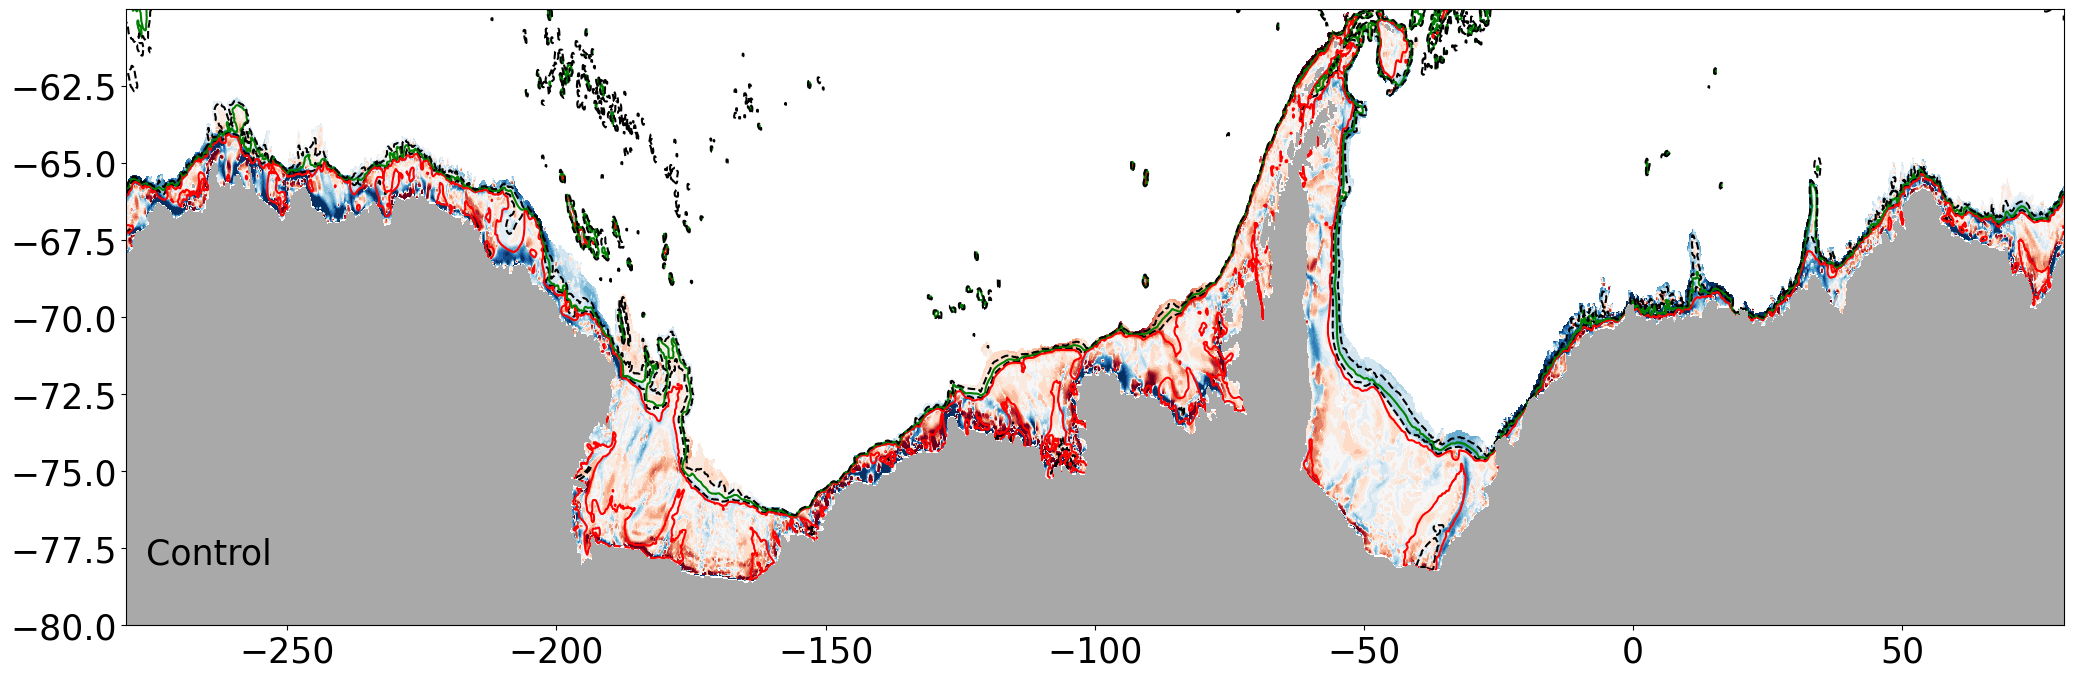

In [41]:
fig, ax = plt.subplots(figsize = (25,8))

# accessom2-01
cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax)
#cs = hu_region.where(hu_region < 2600).plot.contour(levels  = [2500], color = 'k', ax = ax[0])
#changeline_cs('solid')
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax, linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')
cs = hu_region.plot.contour(levels  = [600], color = 'r', ax = ax) #conventional definition for ASC
changeline_cs_r('solid')

cs = hu_region.plot.contour(levels  = [1500], color = 'g', ax = ax) #conventional definition for ASC
changeline_cs_g('solid')
cs = hu_region.plot.contour(levels  = [2000], color = 'k', ax = ax, linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')

ax.set_ylabel('')
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax.text(0.01,0.1,'Control',transform=ax.transAxes)
ax.set_xlabel('')


In [33]:
mask_ASC_N = xr.where((hu<2000) & ( hu > 1500), True, False)
mask_ASC_S = xr.where((hu<1500) & ( hu > 1000), True, False)
mask_ACoC_N = xr.where((hu<1000) & ( hu > 700), True, False)
mask_ACoC_S = xr.where(hu<700, True, False)

In [34]:
import cmocean
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

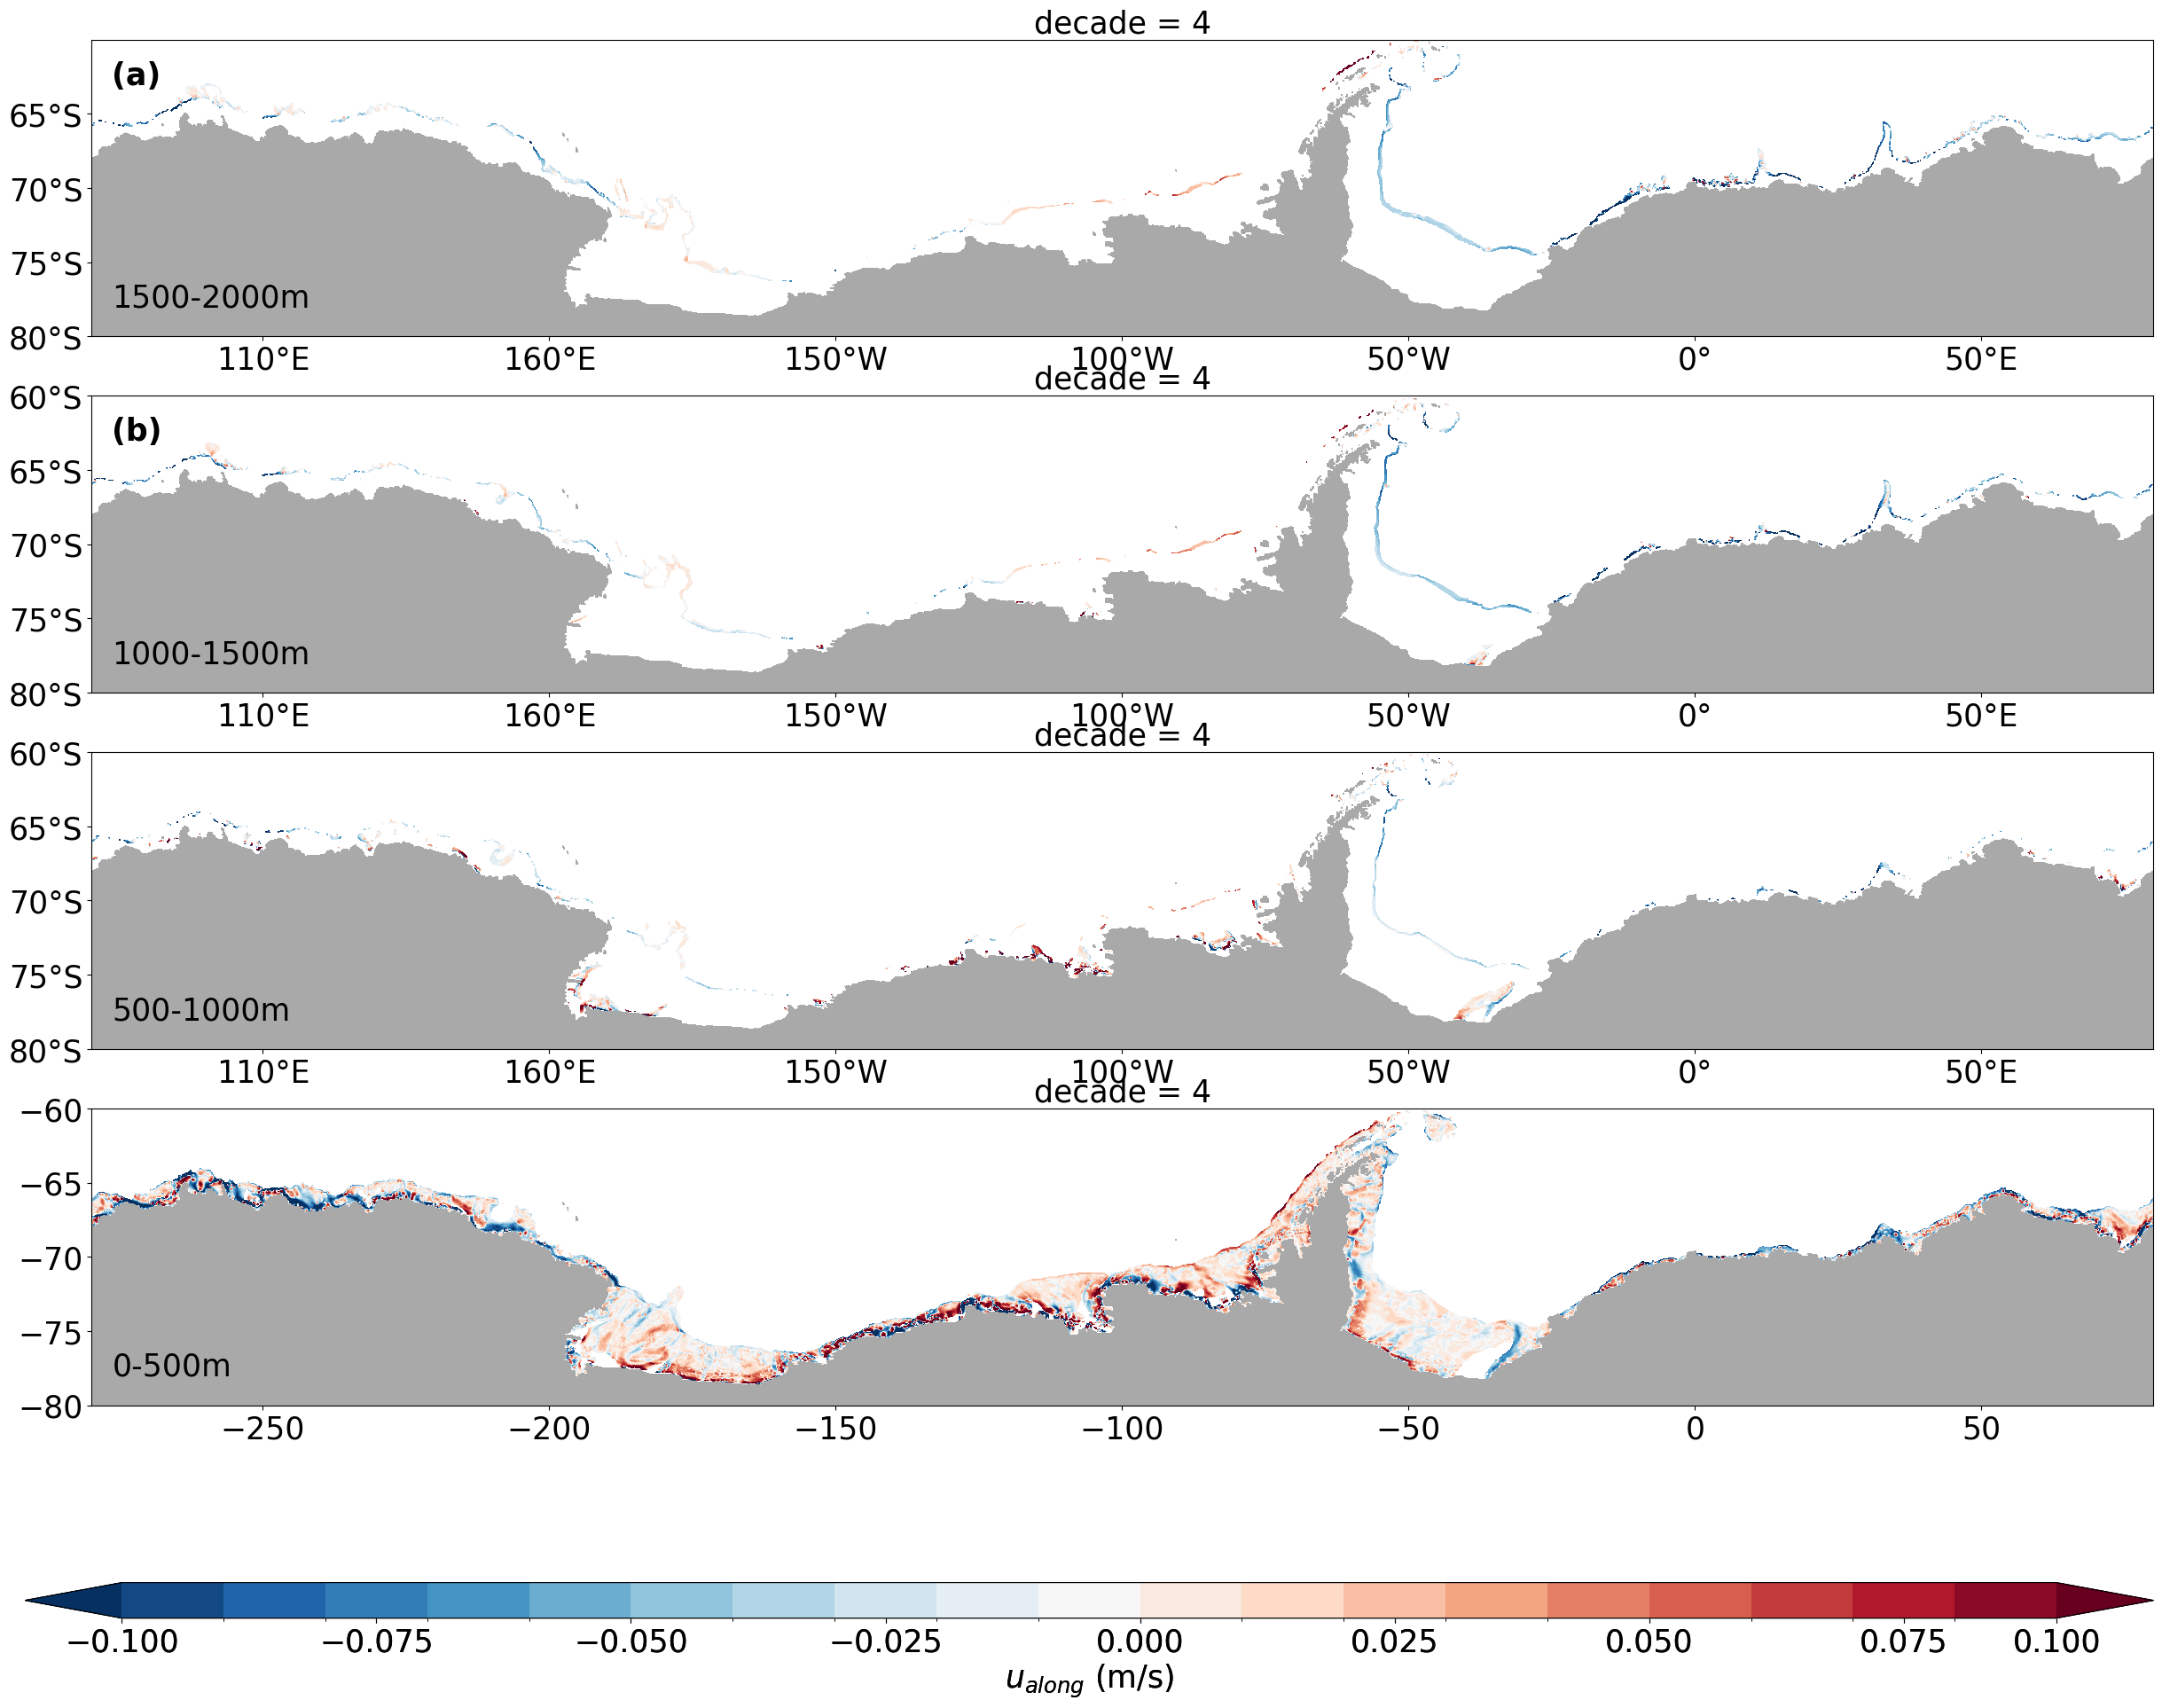

In [58]:
fig, ax = plt.subplots(nrows =4 ,figsize = (30,20))

# accessom2-01
cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ASC_N == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[0])

ax[0].set_ylabel('')
ax[0].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[1].text(0.01,0.1,'1500-2000m',transform=ax[0].transAxes)
ax[0].set_xlabel('')
ax[0].text(0.01,0.85,'(a)', transform=ax[0].transAxes, fontweight = 'bold')



cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ASC_S == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[1])

ax[1].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[1].set_ylim([-80,-60])
ax[1].text(0.01,0.1,'1000-1500m',transform=ax[1].transAxes)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].text(0.01,0.85,'(b)', transform=ax[1].transAxes, fontweight = 'bold')

cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', orientation = 'horizontal', cax = cb_ax, pad = 0.1)
cbar.set_ticks(np.arange(-0.1,0.125,0.025))


cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ACoC_N == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[2])


ax[2].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[2].set_ylim([-80,-60])
ax[2].text(0.01,0.1,'500-1000m',transform=ax[2].transAxes)
ax[2].set_ylabel('')
ax[2].set_xlabel('')

cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ACoC_S == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[3])
#np.flip(deptho, 0).plot.contour(levels  = np.arange(0,4000,500), cmap = 'gray_r' , ax = ax[1]) # shallow is dark ' Greys deep is dark

ax[3].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[3].set_ylim([-80,-60])
ax[3].text(0.01,0.1,'0-500m',transform=ax[3].transAxes)
ax[3].set_ylabel('')
ax[3].set_xlabel('')

cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', orientation = 'horizontal', cax = cb_ax, pad = 0.01)
cbar.set_ticks(np.arange(-0.1,0.125,0.025))

for box in range(3):
    ax[box].yaxis.set_major_formatter(LatitudeFormatter())
    ax[box].xaxis.set_major_formatter(LongitudeFormatter())


## calculate depth av of salt and temp here

In [25]:
def var_ave_mask_isobath(mask, var):
    '''
    var: one time step of 3d variable field
    mask: mask to include relevant isobath range on t grid
    OUTPUT
    var_mask_av: area-average over isobath range
    '''
    var_mask = (var.where(mask == True)*thickness).sum('st_ocean') / thickness.sum('st_ocean')
    print(var_mask)
    ## LINE BELOW DOES NOT DO AREA_T*CLUSTER_MASK_ACCESS
    var_mask_av = grid.integrate(var_mask, axis = ['X','Y']).load()/area_t.where(mask == True).sum().values  
    return var_mask_av

In [36]:
%%time
var = cc.querying.getvar(expt=expt, variable= 'temp', 
                          session=session, frequency='1 monthly', chunks = {'time': 100, 'st_ocean':40, 'yt_ocean':250, 'xt_ocean':1200})\
        .sel(yt_ocean = slice(-79,-60)).isel(time = slice(0,100))#.load()#.chunk({'time': 100, 'yt_ocean':250, 'xt_ocean':1200}).load()
var

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-2

CPU times: user 2.85 s, sys: 230 ms, total: 3.08 s
Wall time: 4.72 s


<xarray.DataArray 'temp' (time: 100, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 48GB
dask.array<getitem, shape=(100, 75, 440, 3600), dtype=float32, chunksize=(3, 40, 240, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [26]:
def var_diff_current(var_name):
    '''
    var_name: str for variable name
    '''
    var = cc.querying.getvar(expt=expt, variable= var_name, 
                          session=session, frequency='1 monthly')\
        .sel(yt_ocean = slice(-79,-60)).chunk({'time':100, 'yt_ocean':250, 'xt_ocean':1200})

    var = var * cluster_mask_access
    print('load')

    diff_var_ACoC_matrix = []
    diff_var_ASC_matrix = []
    for tt in range(6):
        var_t = var.isel(time = slice(tt*100,(tt+1)*100))
        
        var_0_500_ave = var_ave_mask_isobath(mask_0_500, var_t)
        print('0,500')
        var_500_1000_ave = var_ave_mask_isobath(mask_500_1000, var_t)
        print('0,500')
        var_1000_1500_ave = var_ave_mask_isobath(mask_1000_1500, var_t)
        print('0,500')
        var_1500_2000_ave = var_ave_mask_isobath(mask_1500_2000, var_t)
        print('0,500')
    
        diff_var_ACoC = var_0_500_ave - var_500_1000_ave
        diff_var_ASC = var_1000_1500_ave - var_1500_2000_ave
        print( 't = ' + str(tt))
        diff_var_ACoC_matrix.append(diff_var_ACoC)
        diff_var_ASC_matrix.append(diff_var_ASC)
        del diff_var_ACoC, diff_var_ASC, var_0_500_ave, var_500_1000_ave, \
        var_1000_1500_ave, var_1500_2000_ave
    
    return diff_var_ASC_matrix, diff_var_ACoC_matrix

In [27]:
def var_field_isobath(var_name):
    
    ## save temp differences depth-av
    var = cc.querying.getvar(expt=expt, variable= var_name, 
                              session=session, frequency='1 monthly', chunks = {'time': 100,  'yt_ocean':500, 'xt_ocean':1200})\
            .sel(yt_ocean = slice(-79,-60))#.load()
    
    var = var * cluster_mask_access
    print('load')
    
    var_0_500 = []
    var_500_1000 = []
    var_1000_1500 = []
    var_1500_2000 = []

    diff_var_ASC_matrix = []
    for tt in range(6):
        var_t = var.isel(time = slice(tt*100,(tt+1)*100))
        
        var_0_500_ave = var_ave_mask_isobath(mask_0_500, var_t)
        print('0,500')
        var_500_1000_ave = var_ave_mask_isobath(mask_500_1000, var_t)
        print('0,500')
        var_1000_1500_ave = var_ave_mask_isobath(mask_1000_1500, var_t)
        print('0,500')
        var_1500_2000_ave = var_ave_mask_isobath(mask_1500_2000, var_t)
        print('0,500')

        var_0_500.append(var_0_500_ave)
        var_500_1000.append(var_500_1000_ave)
        var_1000_1500.append(var_1000_1500_ave)
        var_1500_2000.append(var_1500_2000_ave)

        del var_0_500_ave, var_500_1000_ave, \
        var_1000_1500_ave, var_1500_2000_ave
    return var_0_500, var_500_1000, var_1000_1500, var_1500_2000

In [37]:
%%time
#temp_0_500, temp_500_1000, temp_1000_1500, temp_1500_2000 = var_field_isobath('temp')
salt_0_500, salt_500_1000, salt_1000_1500, salt_1500_2000 = var_field_isobath('salt')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

load
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

0,500
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
0,500
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
 

In [35]:
xr.concat([temp_0_500[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_0_500.nc')
xr.concat([temp_500_1000[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_500_1000.nc')
xr.concat([temp_1000_1500[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_1000_1500.nc')
xr.concat([temp_1500_2000[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_1500_2000.nc')

In [38]:
xr.concat([salt_0_500[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_0_500.nc')
xr.concat([salt_500_1000[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_500_1000.nc')
xr.concat([salt_1000_1500[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_1000_1500.nc')
xr.concat([salt_1500_2000[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_1500_2000.nc')

In [26]:
import gc 
c.run(gc.collect)

{'tcp://127.0.0.1:34537': 237,
 'tcp://127.0.0.1:37921': 301,
 'tcp://127.0.0.1:40045': 513,
 'tcp://127.0.0.1:41199': 249,
 'tcp://127.0.0.1:43555': 254,
 'tcp://127.0.0.1:43565': 274,
 'tcp://127.0.0.1:44561': 264}

In [56]:
# constants
H_ASC = 1500 #[m]
H_ACoC = 700 # [m]
rho = 135 #[kg/m3]'
alpha = 1e-4 #[K^{-1}]#
beta = 7.5e-4 # [kg/g]
g = 9.81 # [m/s]
f = -1.3e-4 #[s^{-1}]


In [31]:
## calculate thermal wind velocity

In [56]:
%%time
#diff_temp_ASC, diff_temp_ACoC = var_diff_current('temp')
diff_salt_ASC, diff_salt_ACoC = var_diff_current('salt')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

load
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


0,500
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


0,500
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


0,500
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


0,500
t = 0
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2118-05-16 12:00:00 ... 2126-08-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
0,500
<xarray.DataArray (time: 100, yt_ocean: 440, xt_ocean: 3600)> Size: 1GB
dask.array<truediv, shape=(100, 440, 3600), dtype=float64, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.

In [32]:
diff_temp_ACoC[1]

<xarray.DataArray (time: 100)> Size: 800B
array([1.07613248, 1.05981973, 1.05361777, 1.04755654, 1.04561871,
       1.04736015, 1.05081338, 1.07403545, 1.11546338, 1.14501579,
       1.13278647, 1.10123426, 1.07310914, 1.05758733, 1.0526558 ,
       1.04661199, 1.04494408, 1.04574703, 1.04807335, 1.07166055,
       1.11418139, 1.14326928, 1.13007251, 1.09830392, 1.07116045,
       1.05674967, 1.05136986, 1.04622998, 1.04512796, 1.04613998,
       1.04963867, 1.07405341, 1.11776907, 1.14778934, 1.13538812,
       1.10147379, 1.07283277, 1.05718881, 1.05126141, 1.04539661,
       1.04376847, 1.04544108, 1.04860701, 1.07242048, 1.11666282,
       1.14725014, 1.13507852, 1.10193535, 1.07226745, 1.05721739,
       1.0523564 , 1.04654522, 1.04517443, 1.04550718, 1.04873032,
       1.0737716 , 1.11870169, 1.14964995, 1.13804848, 1.10465382,
       1.07640515, 1.06064566, 1.05459904, 1.04981386, 1.04833648,
       1.04792592, 1.05013532, 1.07451658, 1.11912719, 1.15022887,
       1.13880857, 1.10440113, 1.07457694, 1.06038573, 1.05505022,
       1.04952699, 1.04883568, 1.04952934, 1.05175692, 1.07618658,
       1.1213278 , 1.15348364, 1.1407543 , 1.10492713, 1.07435871,
       1.05866323, 1.05310185, 1.0479869 , 1.04688432, 1.0475403 ,
       1.05039407, 1.07536734, 1.12234611, 1.15369077, 1.14120161,
       1.10587772, 1.07582721, 1.06107492, 1.05564603, 1.05023289])
Coordinates:
  * time     (time) object 800B 2118-05-16 12:00:00 ... 2126-08-16 12:00:00

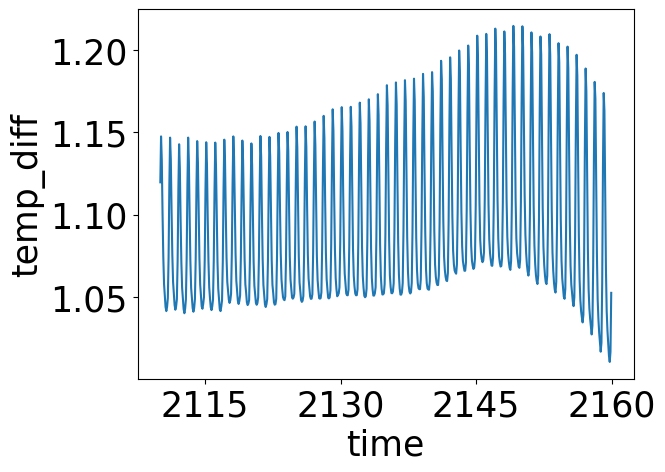

In [35]:
diff_temp_ACoC_t = xr.concat([diff_temp_ACoC[i].rename('temp_diff') for i in range(6)], dim = 'time')
diff_temp_ACoC_t.plot()

TypeError: bad operand type for unary -: 'list'

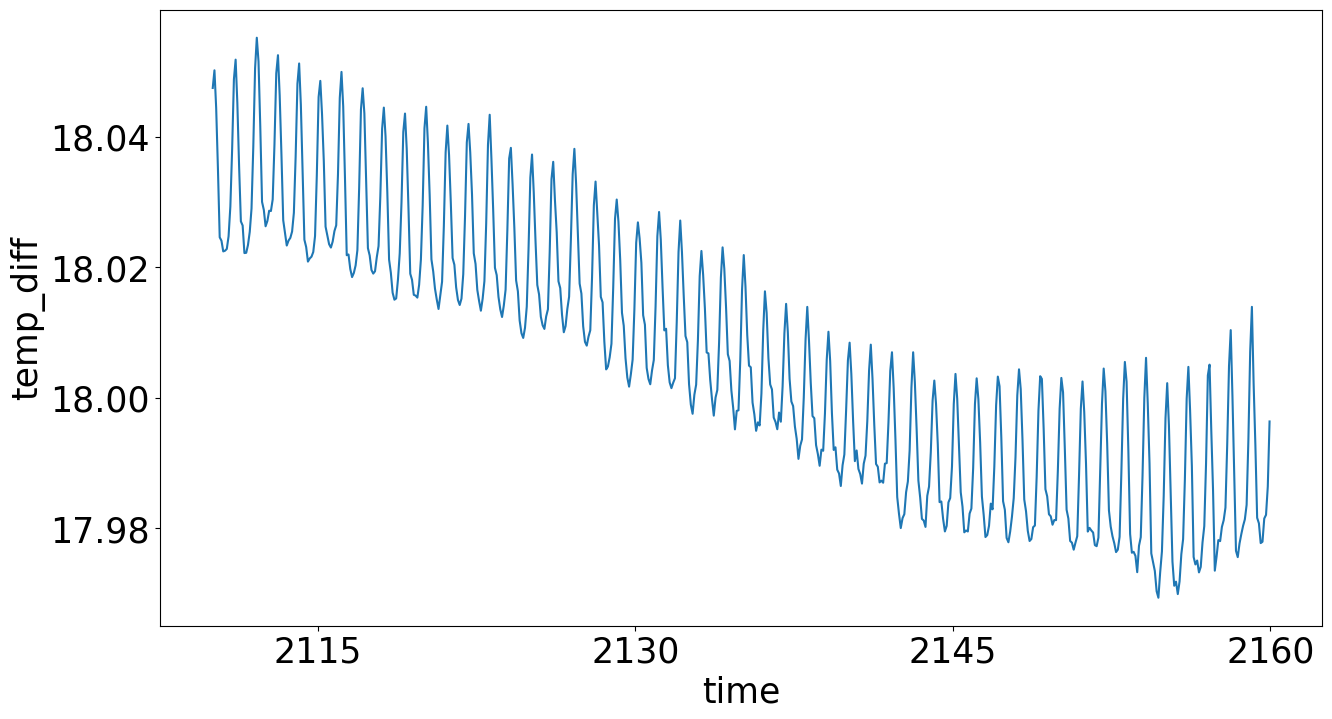

In [73]:
fig, ax = plt.subplots(figsize = (15,8))
(-diff_temp_ASC_t).plot()
ax2 = ax.twinx()
(-diff_temp_ACoC_t).plot(color = 'r')

In [36]:
diff_temp_ASC_t = xr.concat([diff_temp_ASC[i].rename('temp_diff') for i in range(6)], dim = 'time')
diff_temp_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ASC_t.nc')
diff_temp_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ACoC_t.nc')

In [57]:
diff_salt_ACoC_t = xr.concat([diff_salt_ACoC[i].rename('salt_diff') for i in range(6)], dim = 'time')
diff_salt_ASC_t = xr.concat([diff_salt_ASC[i].rename('salt_diff') for i in range(6)], dim = 'time')
diff_salt_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ASC_t.nc')
diff_salt_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ACoC_t.nc')

In [30]:
diff_temp_ASC_t = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ASC_t_scaled.nc')
diff_temp_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ACoC_t_scaled.nc')
diff_salt_ASC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ASC_t_scaled.nc')
diff_salt_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ACoC_t_scaled.nc')

In [31]:
T_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.temp_diff + beta * -diff_salt_ASC_t.salt_diff)
T_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.temp_diff + beta * -diff_salt_ACoC_t.salt_diff)
## salt diff calculates a S - N, minus signs to reverse
# in [Sv]

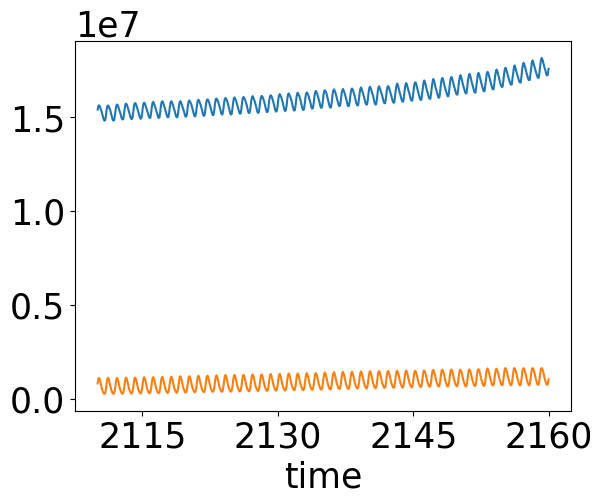

In [51]:
(-T_ASC).plot()
(-T_ACoC).plot()

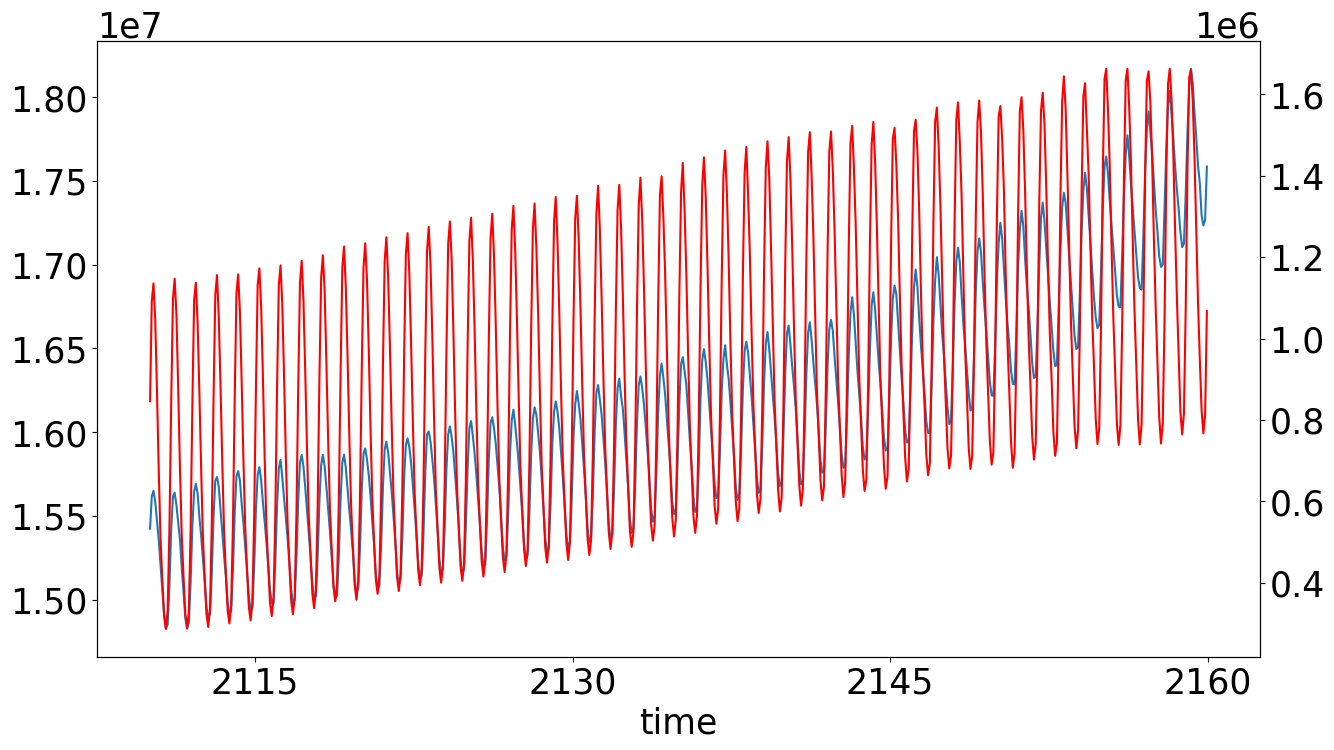

In [53]:
fig, ax = plt.subplots(figsize = (15,8))
(-T_ASC).plot()
#ax.set_ylim([5.92e8,5.98e8])
ax2 = ax.twinx()
(-T_ACoC).plot(color = 'r')
#ax2.set_ylim([2.56e6 ,2.56e6 + 0.06e8])


In [72]:
 temp_comp_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.temp_diff)
salt_comp_ASC = g*H_ASC**2/f *(beta * -diff_salt_ASC_t.salt_diff)
 temp_comp_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.temp_diff)
salt_comp_ACoC = g*H_ACoC**2/f *(beta * -diff_salt_ACoC_t.salt_diff)

## surface difference in temp and salt

In [26]:
def var_surf_diff_current(var_name):
    '''
    var_name: str for variable name
    '''
    var = cc.querying.getvar(expt=expt, variable= var_name, 
                          session=session, frequency='1 monthly')\
        .isel(st_ocean = 0).sel(yt_ocean = slice(-79,-60)).chunk({'time':100, 'yt_ocean':250, 'xt_ocean':1200}).load()
    print(var)
    var = var * cluster_mask_access
    print('load')

    diff_var_ACoC_matrix = []
    diff_var_ASC_matrix = []
    for tt in range(6):
        var_t = var.isel(time = slice(tt*100,(tt+1)*100))
        
        var_0_500_ave = var_surf_mask_isobath(mask_0_500, var_t)
        print('0,500')
        var_500_1000_ave = var_surf_mask_isobath(mask_500_1000, var_t)
        print('0,500')
        var_1000_1500_ave = var_surf_mask_isobath(mask_1000_1500, var_t)
        print('0,500')
        var_1500_2000_ave = var_surf_mask_isobath(mask_1500_2000, var_t)
        print('0,500')
    
        diff_var_ACoC = var_0_500_ave - var_500_1000_ave
        diff_var_ASC = var_1000_1500_ave - var_1500_2000_ave
        print( 't = ' + str(tt))
        diff_var_ACoC_matrix.append(diff_var_ACoC)
        diff_var_ASC_matrix.append(diff_var_ASC)
        del diff_var_ACoC, diff_var_ASC, var_0_500_ave, var_500_1000_ave, \
        var_1000_1500_ave, var_1500_2000_ave
    
    return diff_var_ASC_matrix, diff_var_ACoC_matrix

In [27]:
def var_surf_mask_isobath(mask, var):
    '''
    var: one time step of surf variable field -  no need to depth average
    mask: mask to include relevant isobath range on t grid
    OUTPUT
    var_mask_av: area-average over isobath range
    '''
    var_mask = (var.where(mask == True))
    print(var_mask)
    var_mask_av = grid.integrate(var_mask, axis = ['X','Y']).load()/area_t.where(mask == True).sum().values  
    return var_mask_av

In [28]:
%%time
var = cc.querying.getvar(expt=expt, variable= 'temp', 
                      session=session, frequency='1 monthly')\
    .isel(st_ocean = 0).sel(yt_ocean = slice(-79,-60)).chunk({'time':100, 'yt_ocean':250, 'xt_ocean':1200}).load()
var

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

CPU times: user 44.9 s, sys: 8.5 s, total: 53.4 s
Wall time: 1min 30s


<xarray.DataArray 'temp' (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 4GB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [274.06207, 274.10187, 274.12088, ..., 273.96182, 273.98776,
         274.02127],
        [274.08337, 274.14493, 274.19193, ..., 273.9617 , 273.98276,
         274.0245 ],
        [274.12552, 274.22574, 274.3026 , ..., 273.96167, 273.97882,
         274.03357]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [272.7659 , 272.75293, 272.74176, ..., 272.66064, 272.69006,
         272.72482],
        [272.7596 , 272.74405, 272.72388, ..., 272.66788, 272.68515,
         272.7239 ],
        [272.7479 , 272.7415 , 272.71356, ..., 272.68475, 272.66827,
         272.7099 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [273.71274, 273.79504, 273.81305, ..., 273.7915 , 273.68118,
         273.64856],
        [273.6999 , 273.78214, 273.80103, ..., 273.8318 , 273.70273,
         273.6558 ],
        [273.6788 , 273.7597 , 273.795  , ..., 273.86932, 273.73944,
         273.672  ]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [35]:
%%time
#diff_temp_surf_ASC, diff_temp_surf_ACoC = var_surf_diff_current('temp')
diff_salt_surf_ASC, diff_salt_surf_ACoC = var_surf_diff_current('salt')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

<xarray.DataArray 'salt' (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 4GB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [33.70773 , 33.710873, 33.710995, ..., 33.680878, 33.69277 ,
         33.701355],
        [33.711792, 33.716045, 33.720966, ..., 33.68025 , 33.69291 ,
         33.703156],
        [33.716022, 33.72664 , 33.73809 , ..., 33.679085, 33.692623,
         33.70553 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [33.968742, 33.98295 , 33.998672, ..., 33.892563, 33.914833,
         33.941708],
  

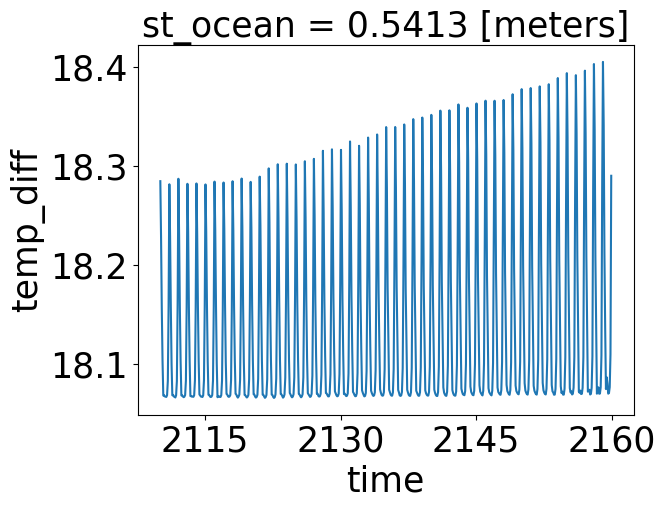

In [34]:
diff_temp_surf_ACoC_t = xr.concat([diff_temp_surf_ACoC[i].rename('temp_diff') for i in range(6)], dim = 'time')
#diff_temp_surf_ACoC_t.plot()
diff_temp_surf_ASC_t.plot()


In [31]:
diff_temp_surf_ASC_t = xr.concat([diff_temp_surf_ASC[i].rename('temp_diff') for i in range(6)], dim = 'time')
diff_temp_surf_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_surf_ASC_t.nc')
diff_temp_surf_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_surf_ACoC_t.nc')

In [36]:
diff_salt_surf_ACoC_t = xr.concat([diff_salt_surf_ACoC[i].rename('salt_diff') for i in range(6)], dim = 'time')
diff_salt_surf_ASC_t = xr.concat([diff_salt_surf_ASC[i].rename('salt_diff') for i in range(6)], dim = 'time')
diff_salt_surf_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_surf_ASC_t.nc')
diff_salt_surf_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_surf_ACoC_t.nc')

In [26]:
## import here
diff_temp_surf_ASC_t = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_surf_ASC_t.nc')
diff_temp_surf_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_surf_ACoC_t.nc')
diff_salt_surf_ASC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_surf_ASC_t.nc')
diff_salt_surf_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_surf_ACoC_t.nc')

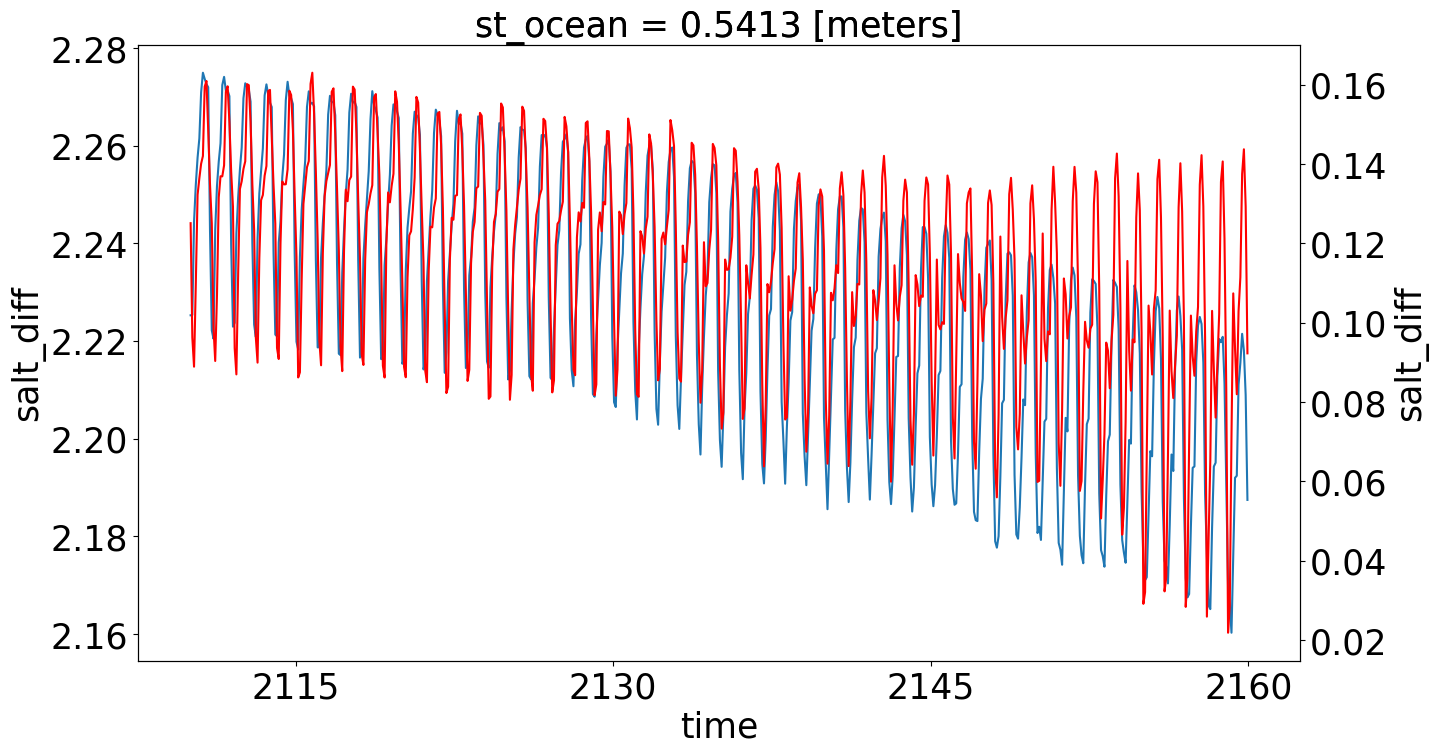

In [37]:
fig, ax = plt.subplots(figsize = (15,8))
diff_salt_surf_ASC_t.plot()
ax2 = ax.twinx()
diff_salt_surf_ACoC_t.plot(color = 'r')

In [27]:
T_ASC_surf = g*H_ASC**2/f *(-alpha  * -diff_temp_surf_ASC_t.temp_diff + beta * -diff_salt_surf_ASC_t.salt_diff)
T_ACoC_surf = g*H_ACoC**2/f *(-alpha  * -diff_temp_surf_ACoC_t.temp_diff + beta * -diff_salt_surf_ACoC_t.salt_diff)
# in [m3/s]/[Sv]

NameError: name 'g' is not defined

In [ ]:
 temp_comp_ASC_surf = g*H_ASC**2/f *(-alpha  * -diff_temp_surf_ASC_t.temp_diff)
salt_comp_ASC_surf = g*H_ASC**2/f *(beta * -diff_salt_surf_ASC_t.salt_diff)
 temp_comp_ACoC_surf = g*H_ACoC**2/f *(-alpha  * -diff_temp_surf_ACoC_t.temp_diff)
salt_comp_ACoC_surf = g*H_ACoC**2/f *(beta * -diff_salt_surf_ACoC_t.salt_diff)

In [43]:
alpha, beta

(0.0001, 0.00075)

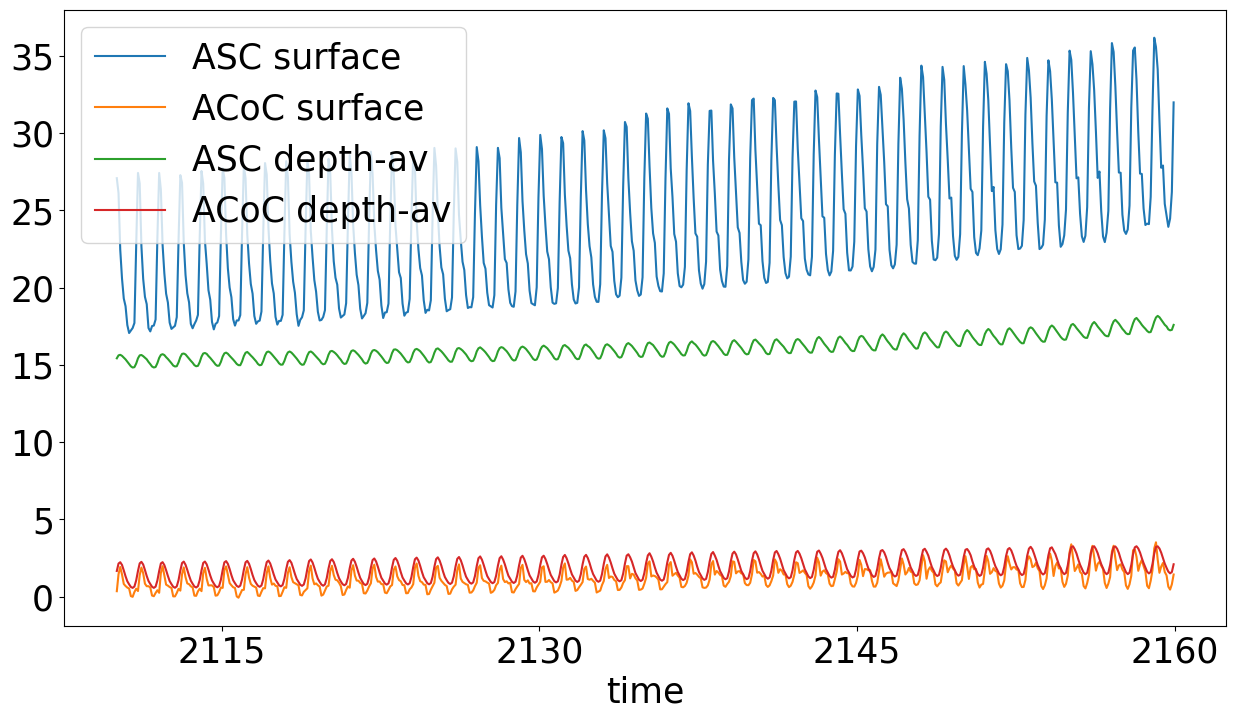

In [44]:
plt.figure(figsize = (15,8))
(-T_ASC_surf/1e6).plot(label = 'ASC surface')
(-T_ACoC_surf/1e6).plot(label = 'ACoC surface')
(-T_ASC/1e6).plot(label = 'ASC depth-av')
(-T_ACoC/1e6).plot(label = 'ACoC depth-av')
plt.legend()

Text(0, 0.5, 'Transport (Sv)')

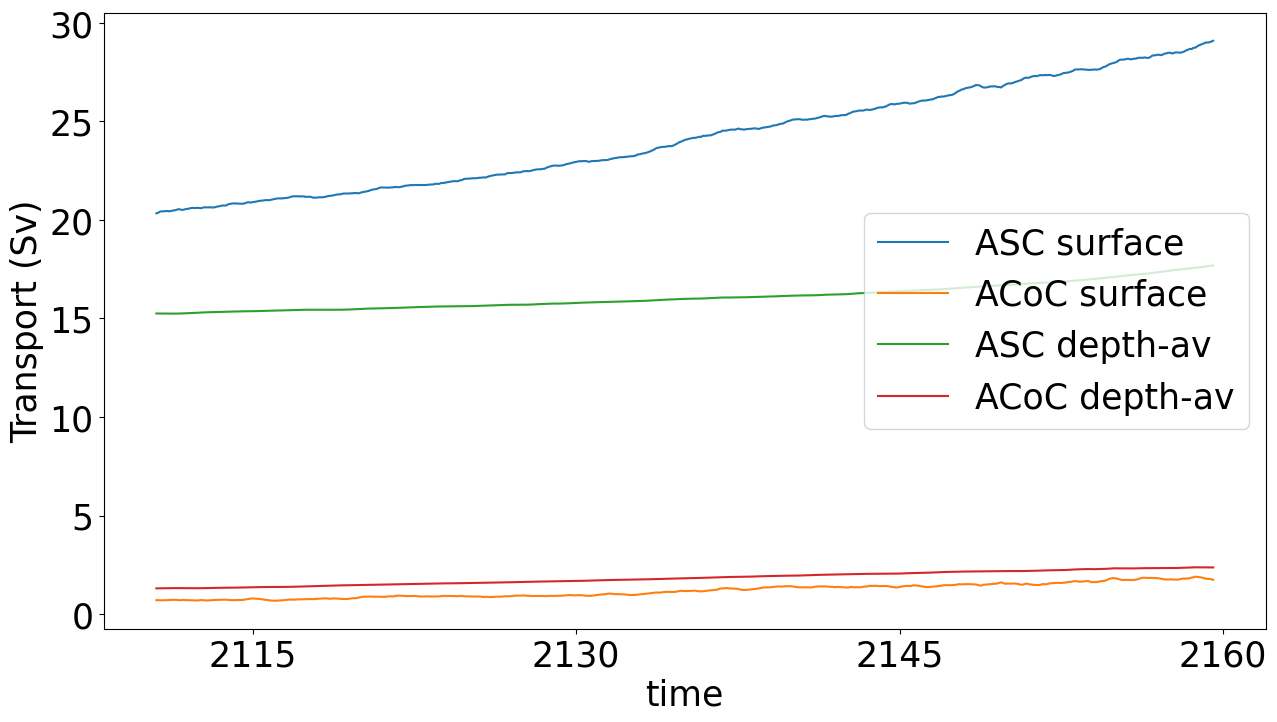

In [92]:
plt.figure(figsize = (15,8))
(-T_ASC_surf/1e6).rolling(time = 12, center = True).mean().plot(label = 'ASC surface')
(-T_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(label = 'ACoC surface')
(-T_ASC/1e6).rolling(time = 12, center = True).mean().plot(label = 'ASC depth-av')
(-T_ACoC/1e6).rolling(time = 12, center = True).mean().plot(label = 'ACoC depth-av')
plt.legend(loc = 'center right')
plt.ylabel('Transport (Sv)')

Text(0.5, 1.0, 'Estimated circumpolar depth-av \n transport through thermal wind balance')

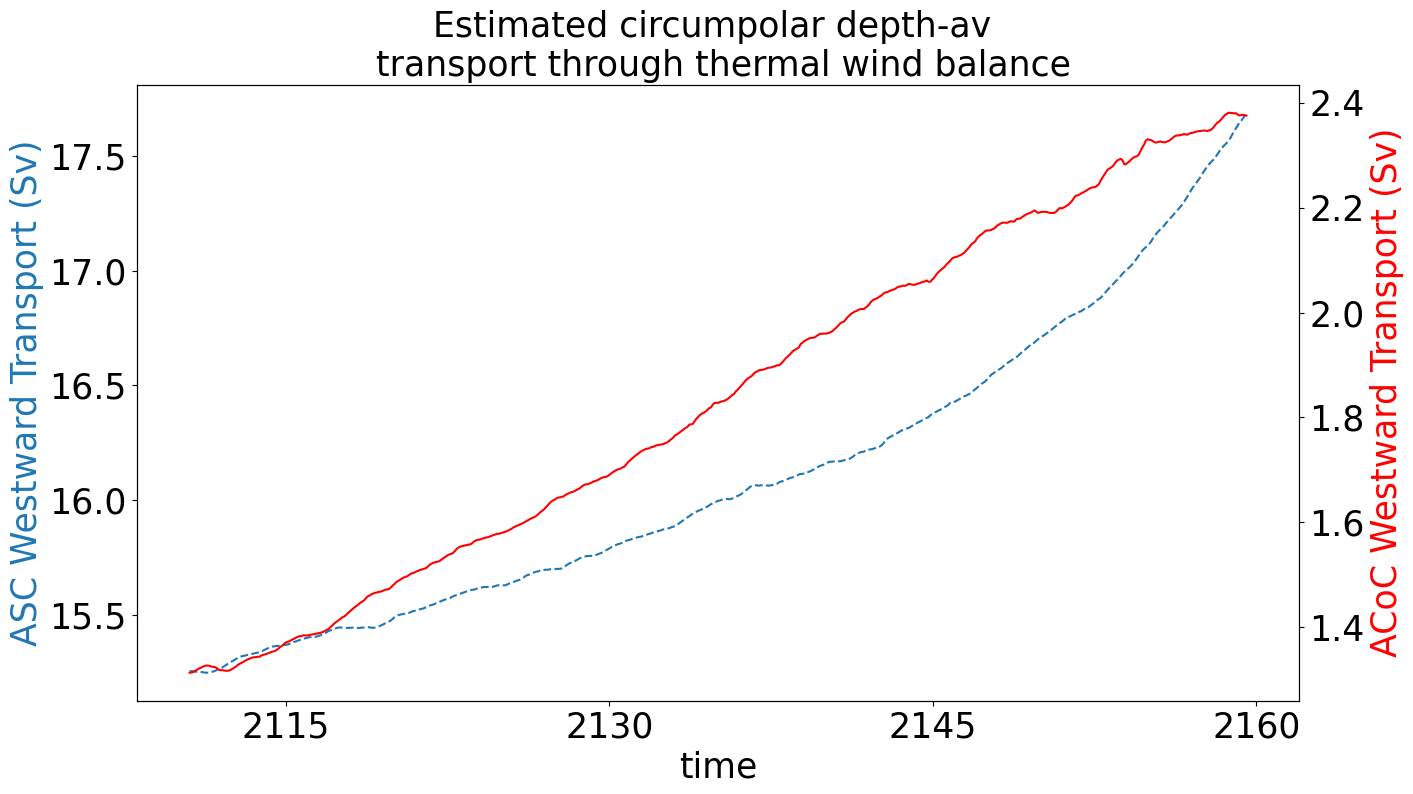

In [46]:
fig, ax = plt.subplots(figsize = (15,8))
(-T_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ASC depth-av')

#ax.set_ylim([15,18])
ax.set_ylabel('ASC Westward Transport (Sv)', color ='C0')

ax2 = ax.twinx()
(-T_ACoC/1e6).rolling(time = 12, center = True).mean().plot(label = 'ACoC depth-av', color = 'r')

#ax2.set_ylim([2.56e6 ,2.56e6 + 0.06e8])
#ax2.set_ylim([0,3])
ax2.set_ylabel('ACoC Westward Transport (Sv)', color ='r')
ax2.set_title('Estimated circumpolar depth-av \n transport through thermal wind balance')

(15.0, 19.0)

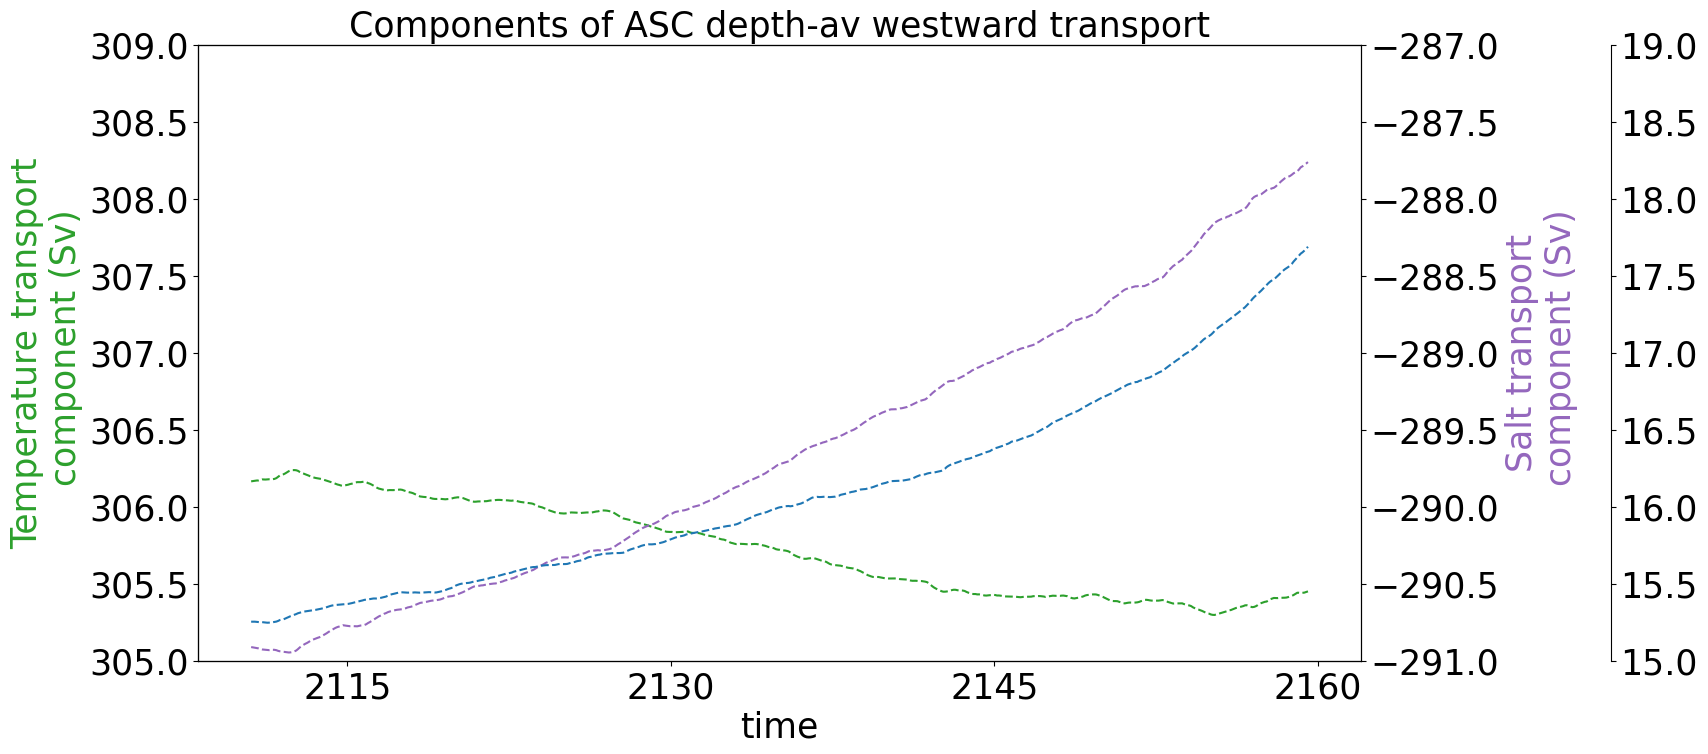

In [96]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([305,309])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([-291,-287])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax.set_title('')
ax2.set_title('Components of ASC depth-av westward transport')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 180))

(-T_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ASC depth-av', ax = ax3)
ax3.set_ylim([15,19])
#(-salt_comp_ASC/1e6 + -temp_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)

#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

(1.0, 3.0)

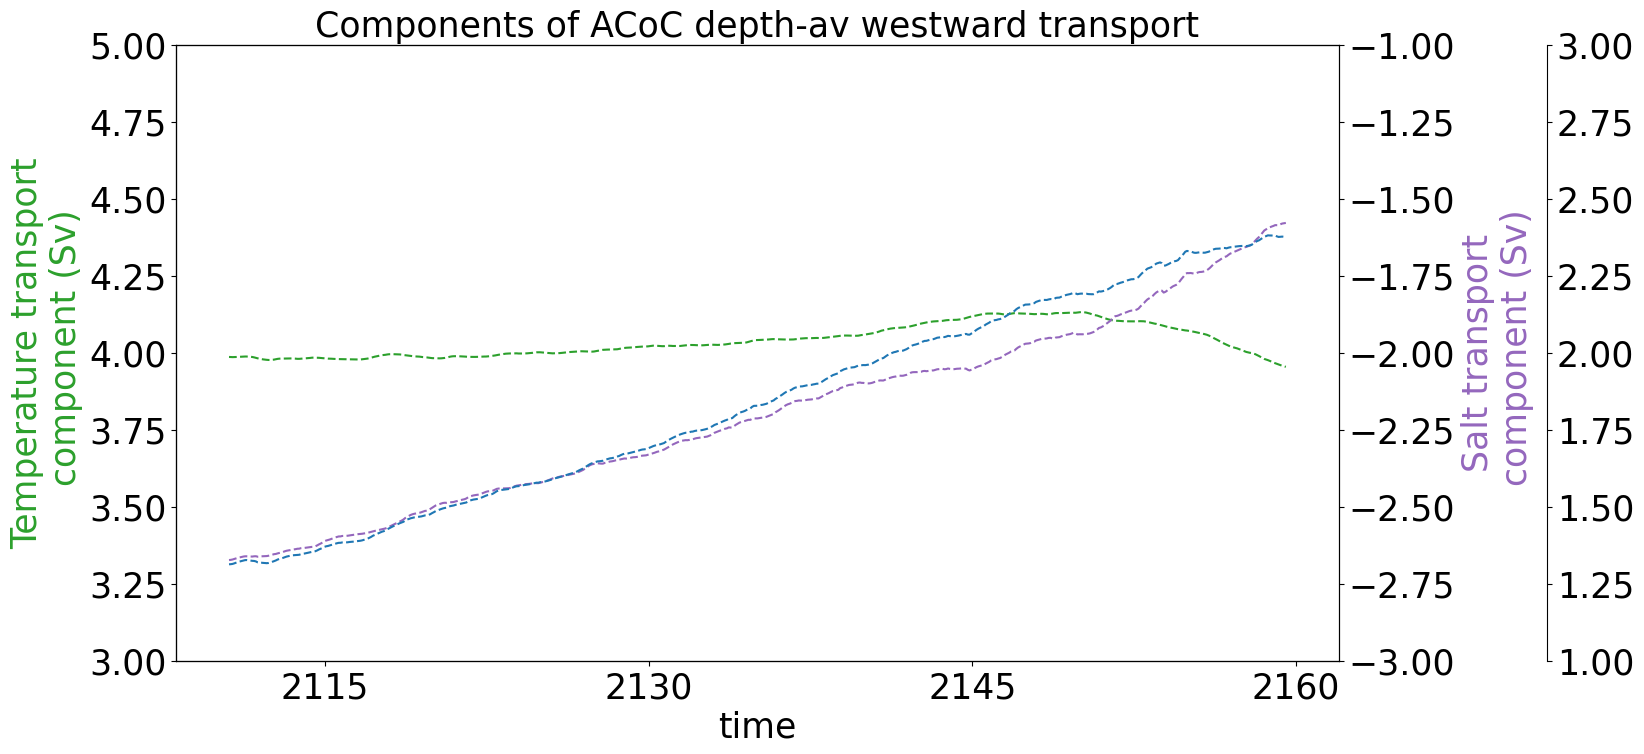

In [94]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([3,5])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([-3,-1])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax.set_title('')
ax2.set_title('Components of ACoC depth-av westward transport')


ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 150))

(-T_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ACoC depth-av', ax = ax3)
#(-salt_comp_ACoC/1e6 + -temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)

ax3.set_ylim([1,3])
#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

Text(0.5, 1.0, 'Estimated circumpolar surface \n transport through thermal wind balance')

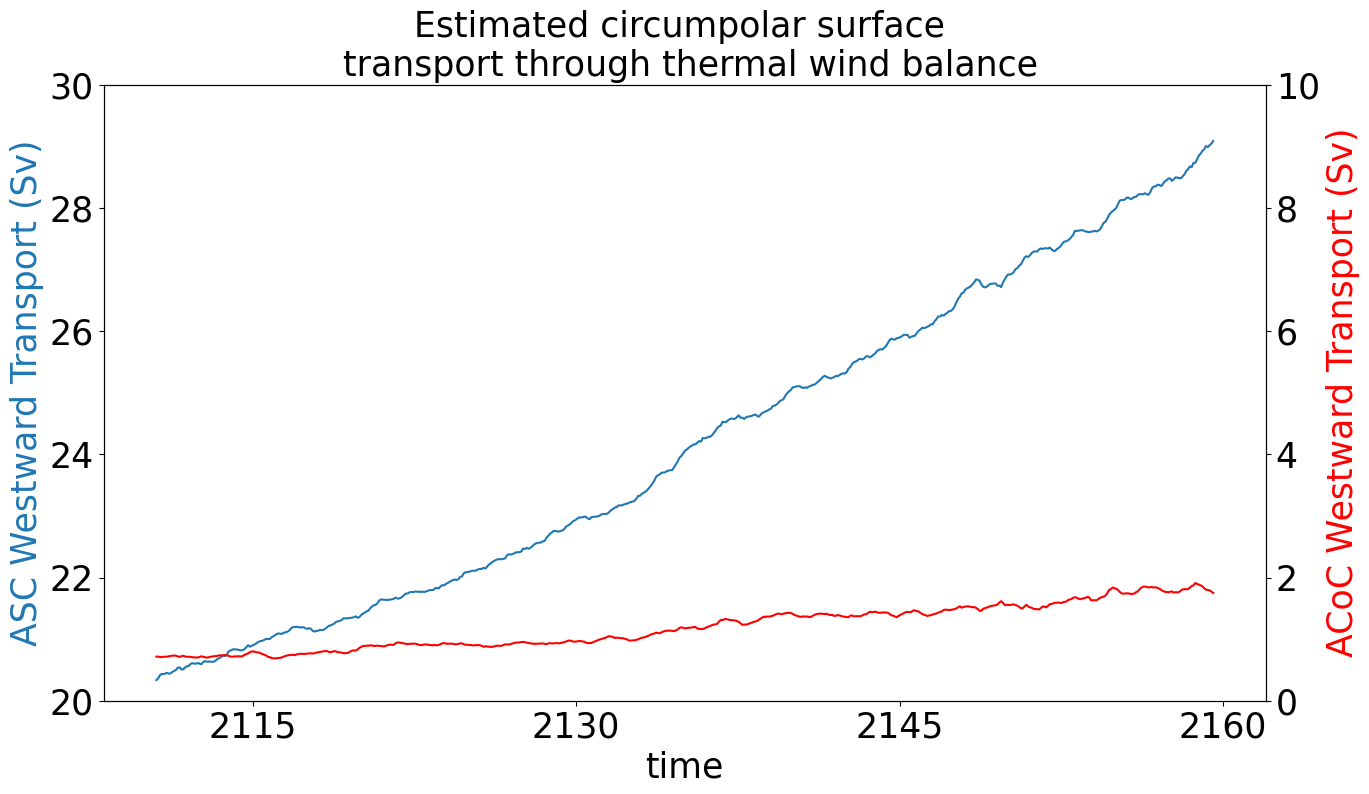

In [91]:
fig, ax = plt.subplots(figsize = (15,8))
(-T_ASC_surf/1e6).rolling(time = 12, center = True).mean().plot(label = 'ASC surface')
ax.set_ylim([20,30])
ax.set_ylabel('ASC Westward Transport (Sv)', color ='C0')
ax.set_title('')

ax2 = ax.twinx()
(-T_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(label = 'ACoC surface', color = 'r')
#ax2.set_ylim([2.56e6 ,2.56e6 + 0.06e8])
ax2.set_ylim([0,10])
ax2.set_ylabel('ACoC Westward Transport (Sv)', color ='r')
ax2.set_title('Estimated circumpolar surface \n transport through thermal wind balance')

Text(0.5, 1.0, 'Components of ASC surface westward transport')

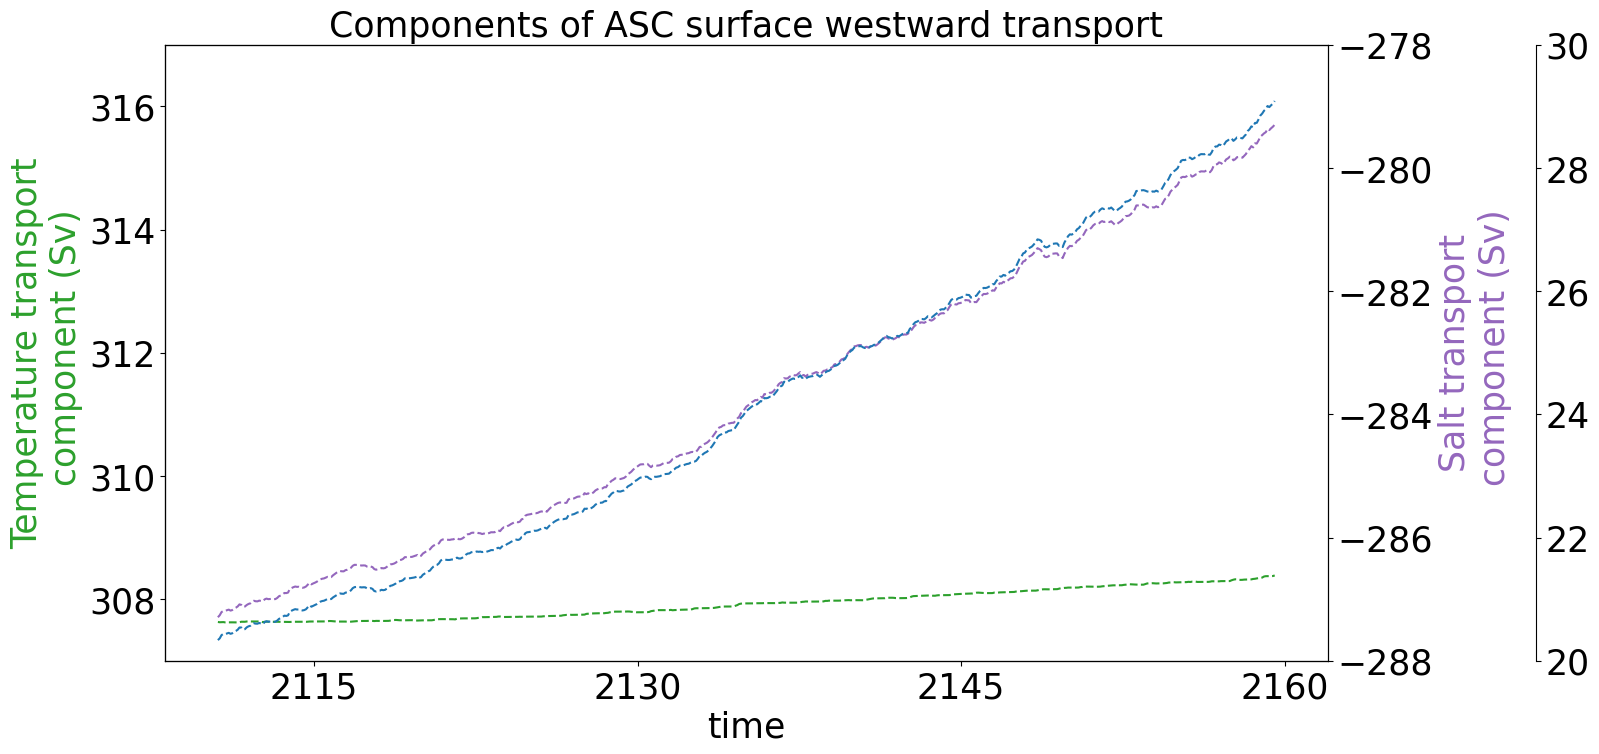

In [83]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ASC_surf/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([307,317])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ASC_surf/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([-288,-278])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 150))

(-T_ASC_surf/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ASC_surf', ax = ax3)
#(-salt_comp_ASC_surf/1e6 + -temp_comp_ASC_surf/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)
ax3.set_ylim([20,30])

ax.set_title('')
ax3.set_title('')

ax2.set_title('Components of ASC surface westward transport')
#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

Text(0.5, 1.0, 'Components of ACoC surface westward transport')

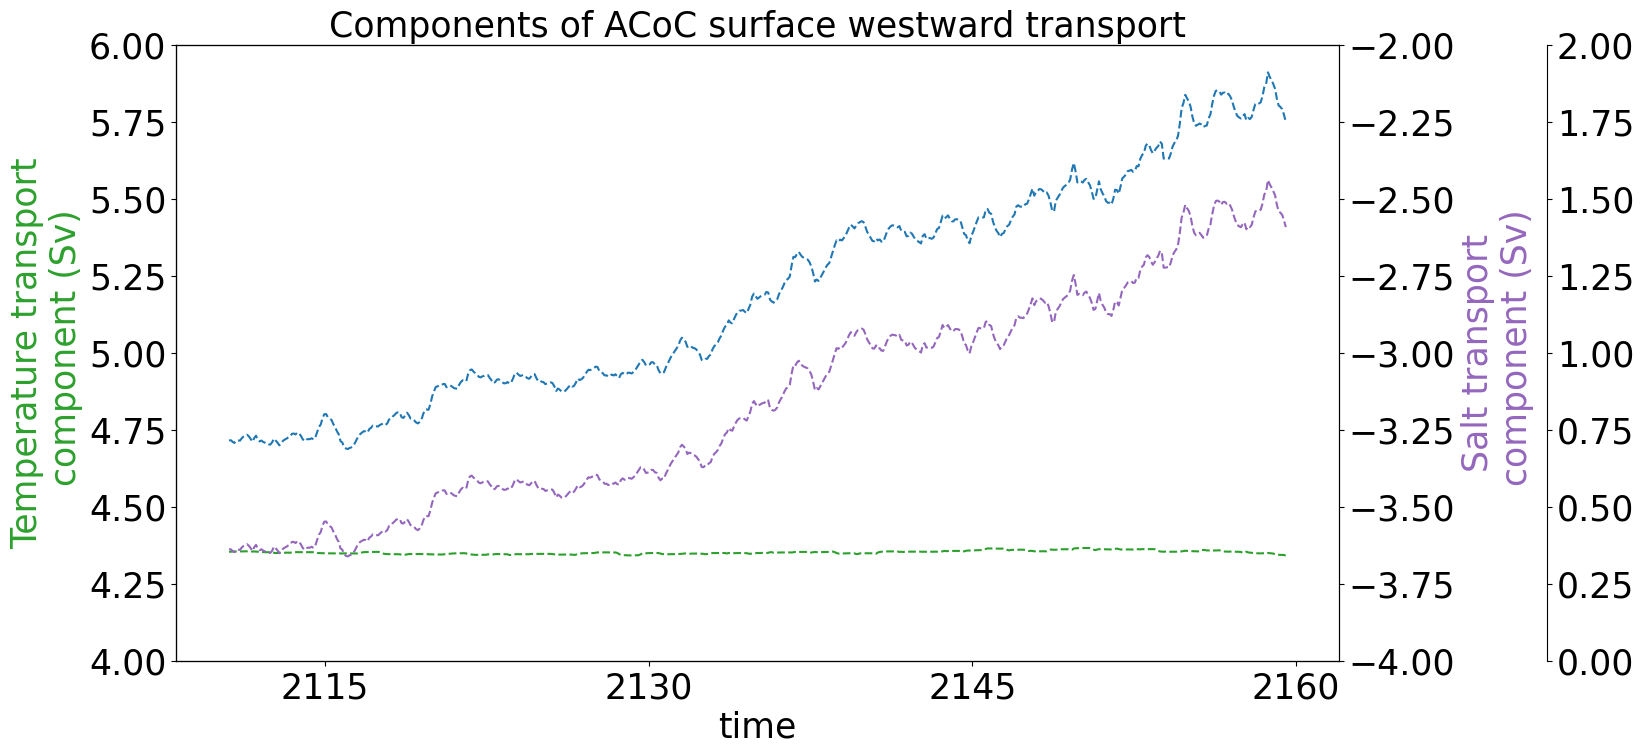

In [90]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([4,6])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([-4,-2])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 150))

(-T_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ACoC_surf', ax = ax3)
#(-salt_comp_ACoC_surf/1e6 + -temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)
ax3.set_ylim([0,2])

ax.set_title('')
ax3.set_title('')

ax2.set_title('Components of ACoC surface westward transport')
#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

In [ ]:
## temperature in each region depth-av

## intake

In [25]:
PATH = '/g/data/cj50/access-om2/raw-output/access-om2-01/' + exp_wthmp
PATH

'/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v13_ryf9091_qian_wthmp'

In [26]:
from access_nri_intake.source import builders

dir(builders)[0:6]

['AccessCm2Builder',
 'AccessEsm15Builder',
 'AccessOm2Builder',
 'AccessOm3Builder',
 'BaseBuilder',
 'Builder']

In [27]:
%%time

builder = builders.AccessOm2Builder(
    path=PATH
).build()

CPU times: user 7.53 s, sys: 3.6 s, total: 11.1 s
Wall time: 41 s


In [ ]:
builder.save(
    name="qian_wthmp", 
    description="Datastore for ACCESS-OM2-01 Qian's MW runs",
)

In [29]:
import intake

esm_datastore = intake.open_esm_datastore(
    "./qian_wthmp.json", 
    columns_with_iterables=["variable"] # This is important
)

esm_datastore

In [29]:
ds = esm_datastore.search(variable="temp", frequency="1mon").to_dask()
ds

<xarray.Dataset> Size: 2TB
Dimensions:   (time: 600, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 2TB dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['temp']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   ['time: mean', 'time: mean', 't...
    intake_esm_attrs:variable_units:          ['K', 'K', 'psu', 'yr', 'm/sec'...
    intake_esm_attrs:filename:                ocean.nc
    intake_esm_attrs:file_id:                 ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

In [30]:
xarray_open_kwargs = {"chunks": {'time': 100, 'st_ocean':40, 'yt_ocean':250, 'xt_ocean':1800}}
#ds = esm_datastore.search(variable="temp", frequency="1mon").to_dask(xarray_open_kwargs = xarray_open_kwargs)
#ds

In [31]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for these docs


In [32]:
def var_ave_mask_isobath(mask, var):
    '''
    var: one time step of 3d variable field
    mask: mask to include relevant isobath range on t grid
    OUTPUT
    var_mask_av: area-average over isobath range
    '''
    var_mask = (var.where(mask == True)*thickness).sum('st_ocean') / thickness.sum('st_ocean')
    print(var_mask)
    var_mask_av = grid.integrate(var_mask, axis = ['X','Y']).compute()/(area_t*cluster_mask_access).where(mask == True).sum().values  
    return var_mask_av

In [112]:
var = esm_datastore.search(variable="temp", frequency="1mon")\
    .to_dask(xarray_open_kwargs = xarray_open_kwargs)\
    .sel(yt_ocean = slice(-79,-60)).isel(time = 0)
var

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

<xarray.Dataset> Size: 475MB
Dimensions:   (st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 8B 2110-01-16 12:00:00
Data variables:
    temp      (st_ocean, yt_ocean, xt_ocean) float32 475MB dask.array<chunksize=(75, 200, 1200), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['temp']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   ['time: mean', 'time: mean', 't...
    intake_esm_attrs:variable_units:          ['K', 'K', 'psu', 'yr', 'm/sec'...
    intake_esm_attrs:filename:                ocean.nc
    intake_esm_attrs:file_id:                 ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

In [107]:
(area_t*cluster_mask_access).where(mask_0_500 == True).sum().values

array(1.2797382e+12, dtype=float32)

In [116]:
var = var*cluster_mask_access
var_mask = (var.where(mask_0_500 == True)*thickness).sum('st_ocean') / thickness.sum('st_ocean')
print(var_mask)
var_mask_av = grid.integrate(var_mask, axis = ['X','Y']).load()/(area_t*cluster_mask_access).where(mask_0_500 == True).sum().values


<xarray.Dataset> Size: 25MB
Dimensions:   (xt_ocean: 3600, yt_ocean: 440)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
    time      object 8B 2110-01-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
Data variables:
    temp      (yt_ocean, xt_ocean) float64 13MB dask.array<chunksize=(200, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [117]:
var_mask_av.values

<bound method Mapping.values of <xarray.Dataset> Size: 16B
Dimensions:  ()
Coordinates:
    time     object 8B 2110-01-16 12:00:00
Data variables:
    temp     float64 8B 272.1>

In [33]:
def var_diff_current_intake(var_name):
    '''
    var_name: str for variable name
    '''
    var = esm_datastore.search(variable=var_name, frequency="1mon")\
        .to_dask(xarray_open_kwargs = xarray_open_kwargs)\
        .sel(yt_ocean = slice(-79,-60))
    
    var = var * cluster_mask_access
    print('load')

    diff_var_ACoC_matrix = []
    diff_var_ASC_matrix = []
    
    var_0_500 = []
    var_500_1000 = []
    var_1000_1500 = []
    var_1500_2000 = []

    for tt in range(6):
        var_t = var.isel(time = slice(tt*100,(tt+1)*100))
        
        var_0_500_ave = var_ave_mask_isobath(mask_0_500, var_t)
        print('0,500')
        var_500_1000_ave = var_ave_mask_isobath(mask_500_1000, var_t)
        print('1,500')
        var_1000_1500_ave = var_ave_mask_isobath(mask_1000_1500, var_t)
        print('2,500')
        var_1500_2000_ave = var_ave_mask_isobath(mask_1500_2000, var_t)
        print('3,500')
    
        var_0_500.append(var_0_500_ave)
        var_500_1000.append(var_500_1000_ave)
        var_1000_1500.append(var_1000_1500_ave)
        var_1500_2000.append(var_1500_2000_ave)
        
        diff_var_ACoC = var_0_500_ave - var_500_1000_ave
        diff_var_ASC = var_1000_1500_ave - var_1500_2000_ave
        print( 't = ' + str(tt))
        diff_var_ACoC_matrix.append(diff_var_ACoC)
        diff_var_ASC_matrix.append(diff_var_ASC)
        del diff_var_ACoC, diff_var_ASC, var_0_500_ave, var_500_1000_ave, \
        var_1000_1500_ave, var_1500_2000_ave
    
    return diff_var_ASC_matrix, diff_var_ACoC_matrix, \
    var_0_500, var_500_1000, var_1000_1500, var_1500_2000

In [34]:
def var_diff_current_intake_chunk(var_name):
    '''
    var_name: str for variable name
    '''
    var = esm_datastore.search(variable=var_name, frequency="1mon")\
        .sel(yt_ocean = slice(-79,-60))
    
    var = var * cluster_mask_access
    print('load')

    diff_var_ACoC_matrix = []
    diff_var_ASC_matrix = []
    
    var_0_500 = []
    var_500_1000 = []
    var_1000_1500 = []
    var_1500_2000 = []

    for tt in range(1):
        var_t = var.isel(time = slice(tt*100,(tt+1)*100))\
        .chunk( {'time': 100, 'st_ocean':80, 'yt_ocean':250, 'xt_ocean':1800})
        
        var_0_500_ave = var_ave_mask_isobath(mask_0_500, var_t)
        print('0,500')
        var_500_1000_ave = var_ave_mask_isobath(mask_500_1000, var_t)
        print('1,500')
        var_1000_1500_ave = var_ave_mask_isobath(mask_1000_1500, var_t)
        print('2,500')
        var_1500_2000_ave = var_ave_mask_isobath(mask_1500_2000, var_t)
        print('3,500')
    
        var_0_500.append(var_0_500_ave)
        var_500_1000.append(var_500_1000_ave)
        var_1000_1500.append(var_1000_1500_ave)
        var_1500_2000.append(var_1500_2000_ave)
        
        diff_var_ACoC = var_0_500_ave - var_500_1000_ave
        diff_var_ASC = var_1000_1500_ave - var_1500_2000_ave
        print( 't = ' + str(tt))
        diff_var_ACoC_matrix.append(diff_var_ACoC)
        diff_var_ASC_matrix.append(diff_var_ASC)
        del diff_var_ACoC, diff_var_ASC, var_0_500_ave, var_500_1000_ave, \
        var_1000_1500_ave, var_1500_2000_ave
    
    return diff_var_ASC_matrix, diff_var_ACoC_matrix, \
    var_0_500, var_500_1000, var_1000_1500, var_1500_2000

In [35]:
def var_diff_current_intake_ctrl(var_name):
    '''
    var_name: str for variable name
    '''
    var = esm_datastore.search(variable=var_name, frequency="1mon")\
        .sel(yt_ocean = slice(-79,-60))
    
    var = var * cluster_mask_access
    print('load')

    diff_var_ACoC_matrix = []
    diff_var_ASC_matrix = []
    
    var_0_500 = []
    var_500_1000 = []
    var_1000_1500 = []
    var_1500_2000 = []

    for tt in range(1):
        var_t = var.isel(time = slice(tt*100,(tt+1)*100))
        
        var_0_500_ave = var_ave_mask_isobath(mask_0_500, var_t)
        print('0,500')
        var_500_1000_ave = var_ave_mask_isobath(mask_500_1000, var_t)
        print('1,500')
        var_1000_1500_ave = var_ave_mask_isobath(mask_1000_1500, var_t)
        print('2,500')
        var_1500_2000_ave = var_ave_mask_isobath(mask_1500_2000, var_t)
        print('3,500')
    
        var_0_500.append(var_0_500_ave)
        var_500_1000.append(var_500_1000_ave)
        var_1000_1500.append(var_1000_1500_ave)
        var_1500_2000.append(var_1500_2000_ave)
        
        diff_var_ACoC = var_0_500_ave - var_500_1000_ave
        diff_var_ASC = var_1000_1500_ave - var_1500_2000_ave
        print( 't = ' + str(tt))
        diff_var_ACoC_matrix.append(diff_var_ACoC)
        diff_var_ASC_matrix.append(diff_var_ASC)
        del diff_var_ACoC, diff_var_ASC, var_0_500_ave, var_500_1000_ave, \
        var_1000_1500_ave, var_1500_2000_ave
    
    return diff_var_ASC_matrix, diff_var_ACoC_matrix, \
    var_0_500, var_500_1000, var_1000_1500, var_1500_2000

In [ ]:
%%time
diff_temp_ASC_matrix_ctrl, diff_temp_ACoC_matrix_ctrl, \
    temp_0_500_ctrl, temp_500_1000_ctrl, temp_1000_1500_ctrl, temp_1500_2000_ctrl = var_diff_current_intake_ctrl('temp')

In [ ]:
%%time
diff_temp_ASC_matrix_chunk, diff_temp_ACoC_matrix_chunk, \
    temp_0_500_chunk, temp_500_1000_chunk, temp_1000_1500_chunk, temp_1500_2000_chunk = var_diff_current_intake_chunk('temp')

In [36]:
%%time
diff_temp_ASC_matrix, diff_temp_ACoC_matrix, \
    temp_0_500, temp_500_1000, temp_1000_1500, temp_1500_2000 = var_diff_current_intake('temp')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 1800. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

load
<xarray.Dataset> Size: 1GB
Dimensions:   (xt_ocean: 3600, yt_ocean: 440, time: 100)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
Data variables:
    temp      (time, yt_ocean, xt_ocean) float64 1GB dask.array<chunksize=(3, 200, 1200), meta=np.ndarray>


2024-08-20 13:01:15,438 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('concatenate-open_dataset-temp-getitem-b396b7f90769aa94941ee31805a3c70c', 18, 0, 1, 1))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-08-20 13:01:15,438 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('concatenate-open_dataset-temp-getitem-b396b7f90769aa94941ee31805a3c70c', 18, 0, 0, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-08-20 13:01:15,439 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('concatenate-open_dataset-temp-getitem-b396b7f90769aa94941ee31

KeyboardInterrupt: 

In [37]:
import gc
c.run(gc.collect)

{}

In [ ]:
diff_salt_ASC_matrix, diff_salt_ACoC_matrix, \
    salt_0_500, salt_500_1000, salt_1000_1500, salt_1500_2000 = var_diff_current_intake('salt')

In [ ]:
xr.concat([temp_0_500[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_0_500_scaled.nc')
xr.concat([temp_500_1000[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_500_1000_scaled.nc')
xr.concat([temp_1000_1500[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_1000_1500_scaled.nc')
xr.concat([temp_1500_2000[i].rename('temp') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_1500_2000_scaled.nc')

In [ ]:
xr.concat([salt_0_500[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_0_500_scaled.nc')
xr.concat([salt_500_1000[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_500_1000_scaled.nc')
xr.concat([salt_1000_1500[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_1000_1500_scaled.nc')
xr.concat([salt_1500_2000[i].rename('salt') for i in range(6)], dim = 'time').to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_1500_2000_scaled.nc')

In [ ]:
diff_temp_ASC_t = xr.concat([diff_temp_ASC_matrix[i].rename('temp_diff') for i in range(6)], dim = 'time')
diff_temp_ACoC_t = xr.concat([diff_temp_ACoC_matrix[i].rename('temp_diff') for i in range(6)], dim = 'time')

diff_temp_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ASC_t_scaled.nc')
diff_temp_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ACoC_t_scaled.nc')

In [ ]:
diff_salt_ACoC_t = xr.concat([diff_salt_ACoC_matrix[i].rename('salt_diff') for i in range(6)], dim = 'time')
diff_salt_ASC_t = xr.concat([diff_salt_ASC_matrix[i].rename('salt_diff') for i in range(6)], dim = 'time')
diff_salt_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ASC_t_scaled.nc')
diff_salt_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ACoC_t_scaled.nc')

## plotting master

In [26]:
diff_temp_ASC_t = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ASC_t_scaled.nc')
diff_temp_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ACoC_t_scaled.nc')
diff_salt_ASC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ASC_t_scaled.nc')
diff_salt_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ACoC_t_scaled.nc')

In [27]:
# constants
H_ASC = 1500 #[m]
H_ACoC = 700 # [m]
rho = 135 #[kg/m3]'
alpha = 1e-4 #[K^{-1}]#
beta = 7.5e-4 # [kg/g]
g = 9.81 # [m/s]
f = -1.3e-4 #[s^{-1}]


In [28]:
T_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.temp + beta * -diff_salt_ASC_t.salt)
T_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.temp + beta * -diff_salt_ACoC_t.salt)
## salt diff calculates a S - N, minus signs to reverse
# in [Sv]

In [29]:
 temp_comp_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.temp)
salt_comp_ASC = g*H_ASC**2/f *(beta * -diff_salt_ASC_t.salt)
 temp_comp_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.temp)
salt_comp_ACoC = g*H_ACoC**2/f *(beta * -diff_salt_ACoC_t.salt)

Text(0.5, 1.0, 'Estimated circumpolar depth-av \n transport through thermal wind balance')

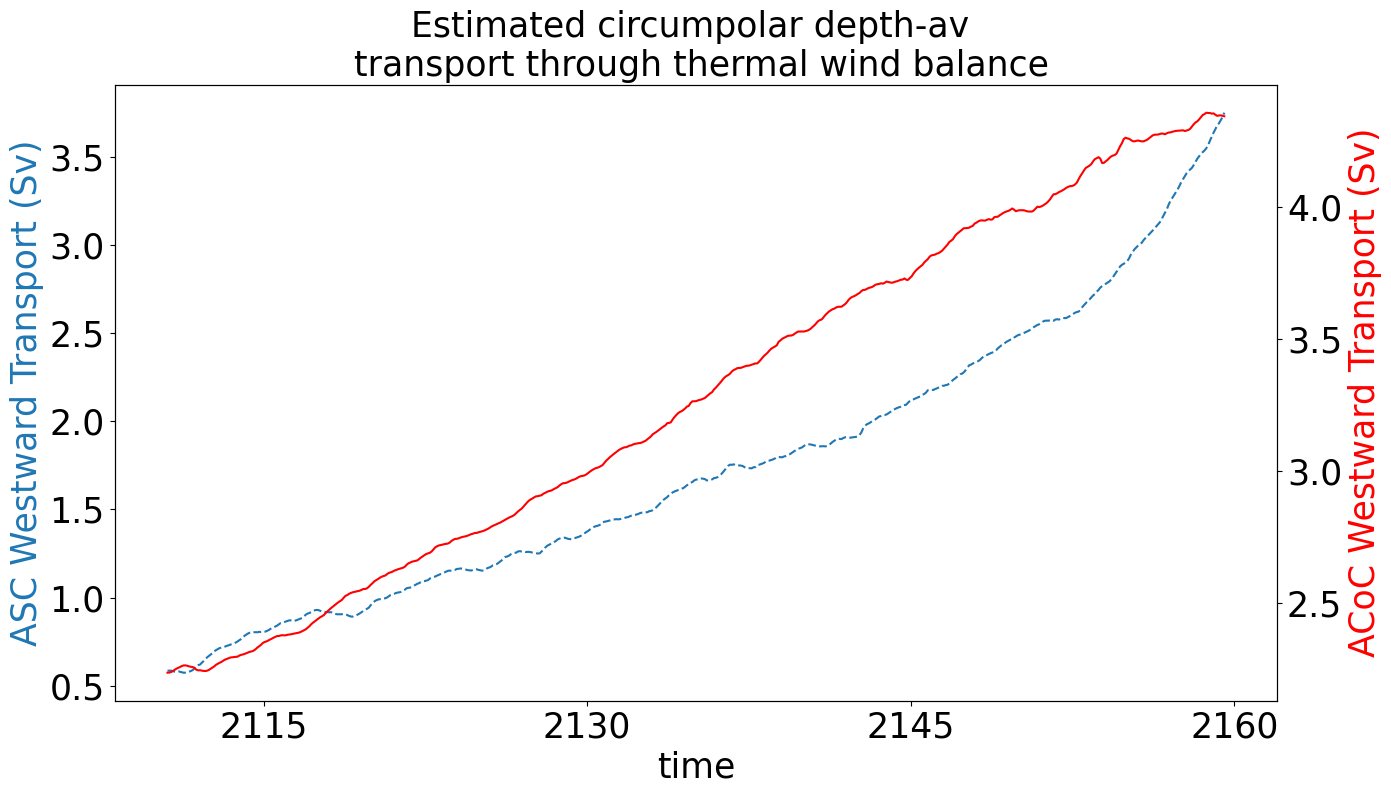

In [61]:
fig, ax = plt.subplots(figsize = (15,8))
(-T_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ASC depth-av')

#ax.set_ylim([15,18])
ax.set_ylabel('ASC Westward Transport (Sv)', color ='C0')

ax2 = ax.twinx()
(-T_ACoC/1e6).rolling(time = 12, center = True).mean().plot(label = 'ACoC depth-av', color = 'r')

#ax2.set_ylim([2.56e6 ,2.56e6 + 0.06e8])
#ax2.set_ylim([0,3])
ax2.set_ylabel('ACoC Westward Transport (Sv)', color ='r')
ax2.set_title('Estimated circumpolar depth-av \n transport through thermal wind balance')

Text(0, 0.5, 'ASC transport (Sv)')

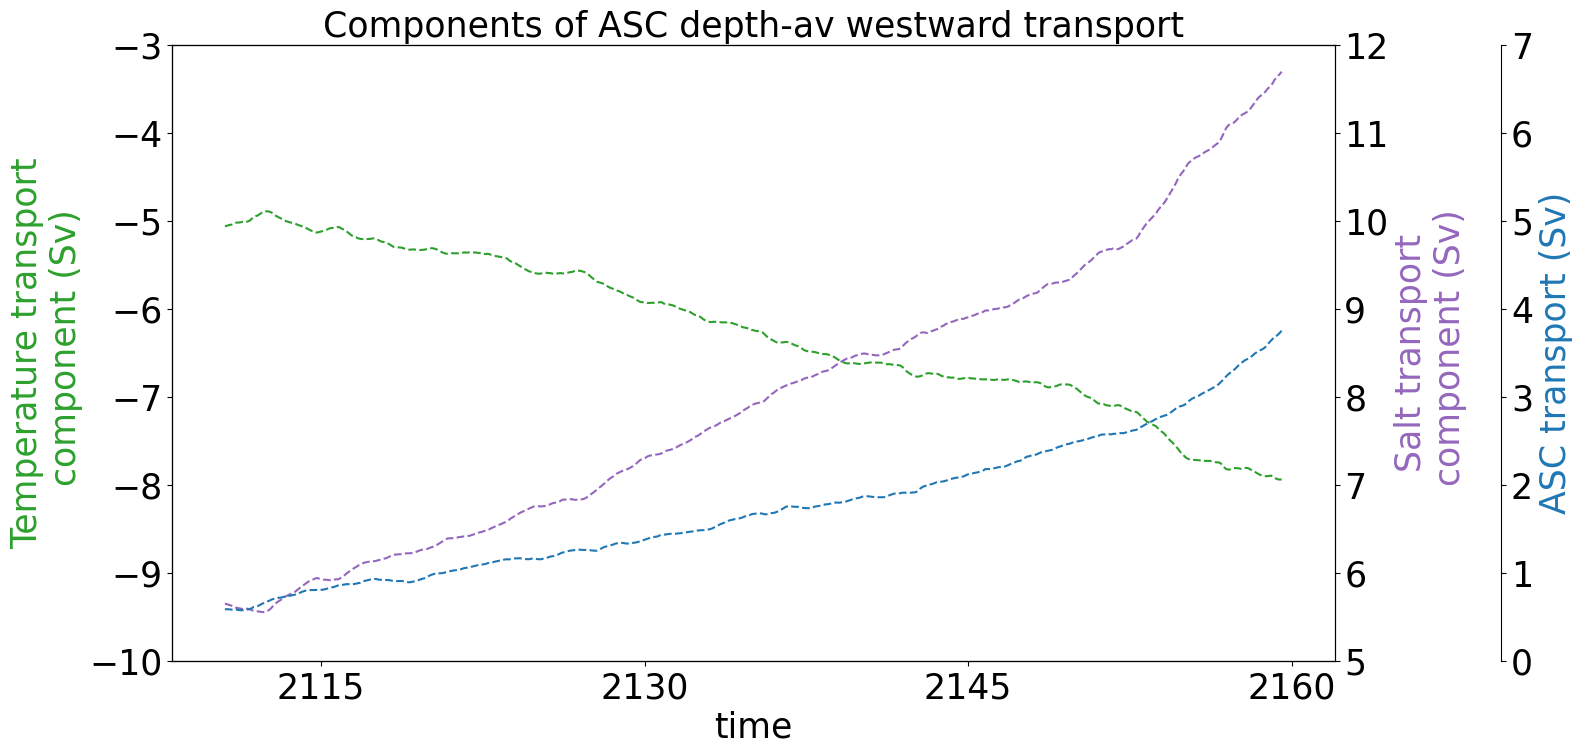

In [73]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([-10,-3])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([5,12])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax.set_title('')
ax2.set_title('Components of ASC depth-av westward transport')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 120))


(-T_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ASC depth-av', ax = ax3)
ax3.set_ylim([0,7])
ax3.set_ylabel('ASC transport (Sv)', color= 'C0')

#(-salt_comp_ASC/1e6 + -temp_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)

#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

(2.0, 5.0)

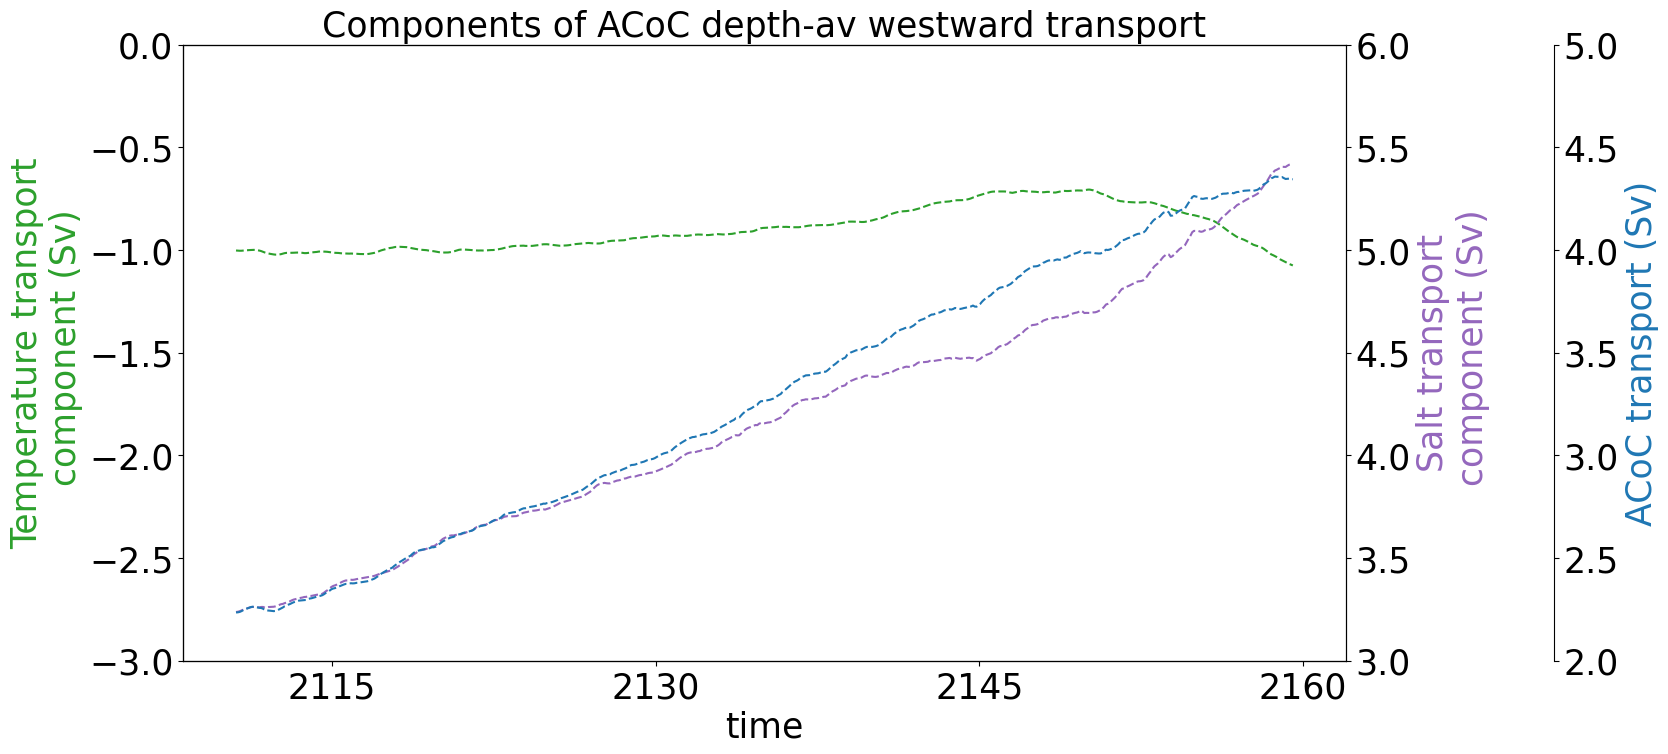

In [74]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([-3,0])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([3,6])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax.set_title('')
ax2.set_title('Components of ACoC depth-av westward transport')


ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 150))

(-T_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ACoC depth-av', ax = ax3)
#(-salt_comp_ACoC/1e6 + -temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)
ax3.set_ylabel('ACoC transport (Sv)', color= 'C0')

ax3.set_ylim([2,5])
#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

## temp differences isobath

In [30]:
FileList = ['temp_0_500.nc','temp_1000_1500.nc',  'temp_1500_2000.nc','temp_500_1000.nc']
temp_dir = ['/g/data/v45/qo9901/MW-perturb-ASC-data/' + (FileList[i]) for i in range(len(FileList))]
[temp_0_500,  temp_1000_1500,  temp_1500_2000,  temp_500_1000] = \
    [xr.open_mfdataset(temp_dir[i]) for i in range(len(FileList))]
temp_0_500

<xarray.Dataset> Size: 10kB
Dimensions:  (time: 600)
Coordinates:
  * time     (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables:
    temp     (time) float64 5kB dask.array<chunksize=(600,), meta=np.ndarray>

In [31]:
FileList = ['salt_0_500.nc','salt_1000_1500.nc',  'salt_1500_2000.nc','salt_500_1000.nc']
salt_dir = ['/g/data/v45/qo9901/MW-perturb-ASC-data/' + (FileList[i]) for i in range(len(FileList))]
[salt_0_500,  salt_1000_1500,  salt_1500_2000,  salt_500_1000] = \
    [xr.open_mfdataset(salt_dir[i]) for i in range(len(FileList))]
salt_0_500

<xarray.Dataset> Size: 10kB
Dimensions:  (time: 600)
Coordinates:
  * time     (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables:
    salt     (time) float64 5kB dask.array<chunksize=(600,), meta=np.ndarray>

In [32]:
temp_0_500_scaled = temp_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t*cluster_mask_access).where(mask_0_500 == True).sum().values
temp_500_1000_scaled = temp_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t*cluster_mask_access).where(mask_500_1000 == True).sum().values
temp_1000_1500_scaled = temp_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t*cluster_mask_access).where(mask_1000_1500 == True).sum().values
temp_1500_2000_scaled = temp_1500_2000*area_t.where(mask_1500_2000 == True).sum().values/(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values

salt_0_500_scaled = salt_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t*cluster_mask_access).where(mask_0_500 == True).sum().values
salt_500_1000_scaled = salt_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t*cluster_mask_access).where(mask_500_1000 == True).sum().values
salt_1000_1500_scaled = salt_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t*cluster_mask_access).where(mask_1000_1500 == True).sum().values
salt_1500_2000_scaled = salt_1500_2000*area_t.where(mask_1500_2000 == True).sum().values/(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values


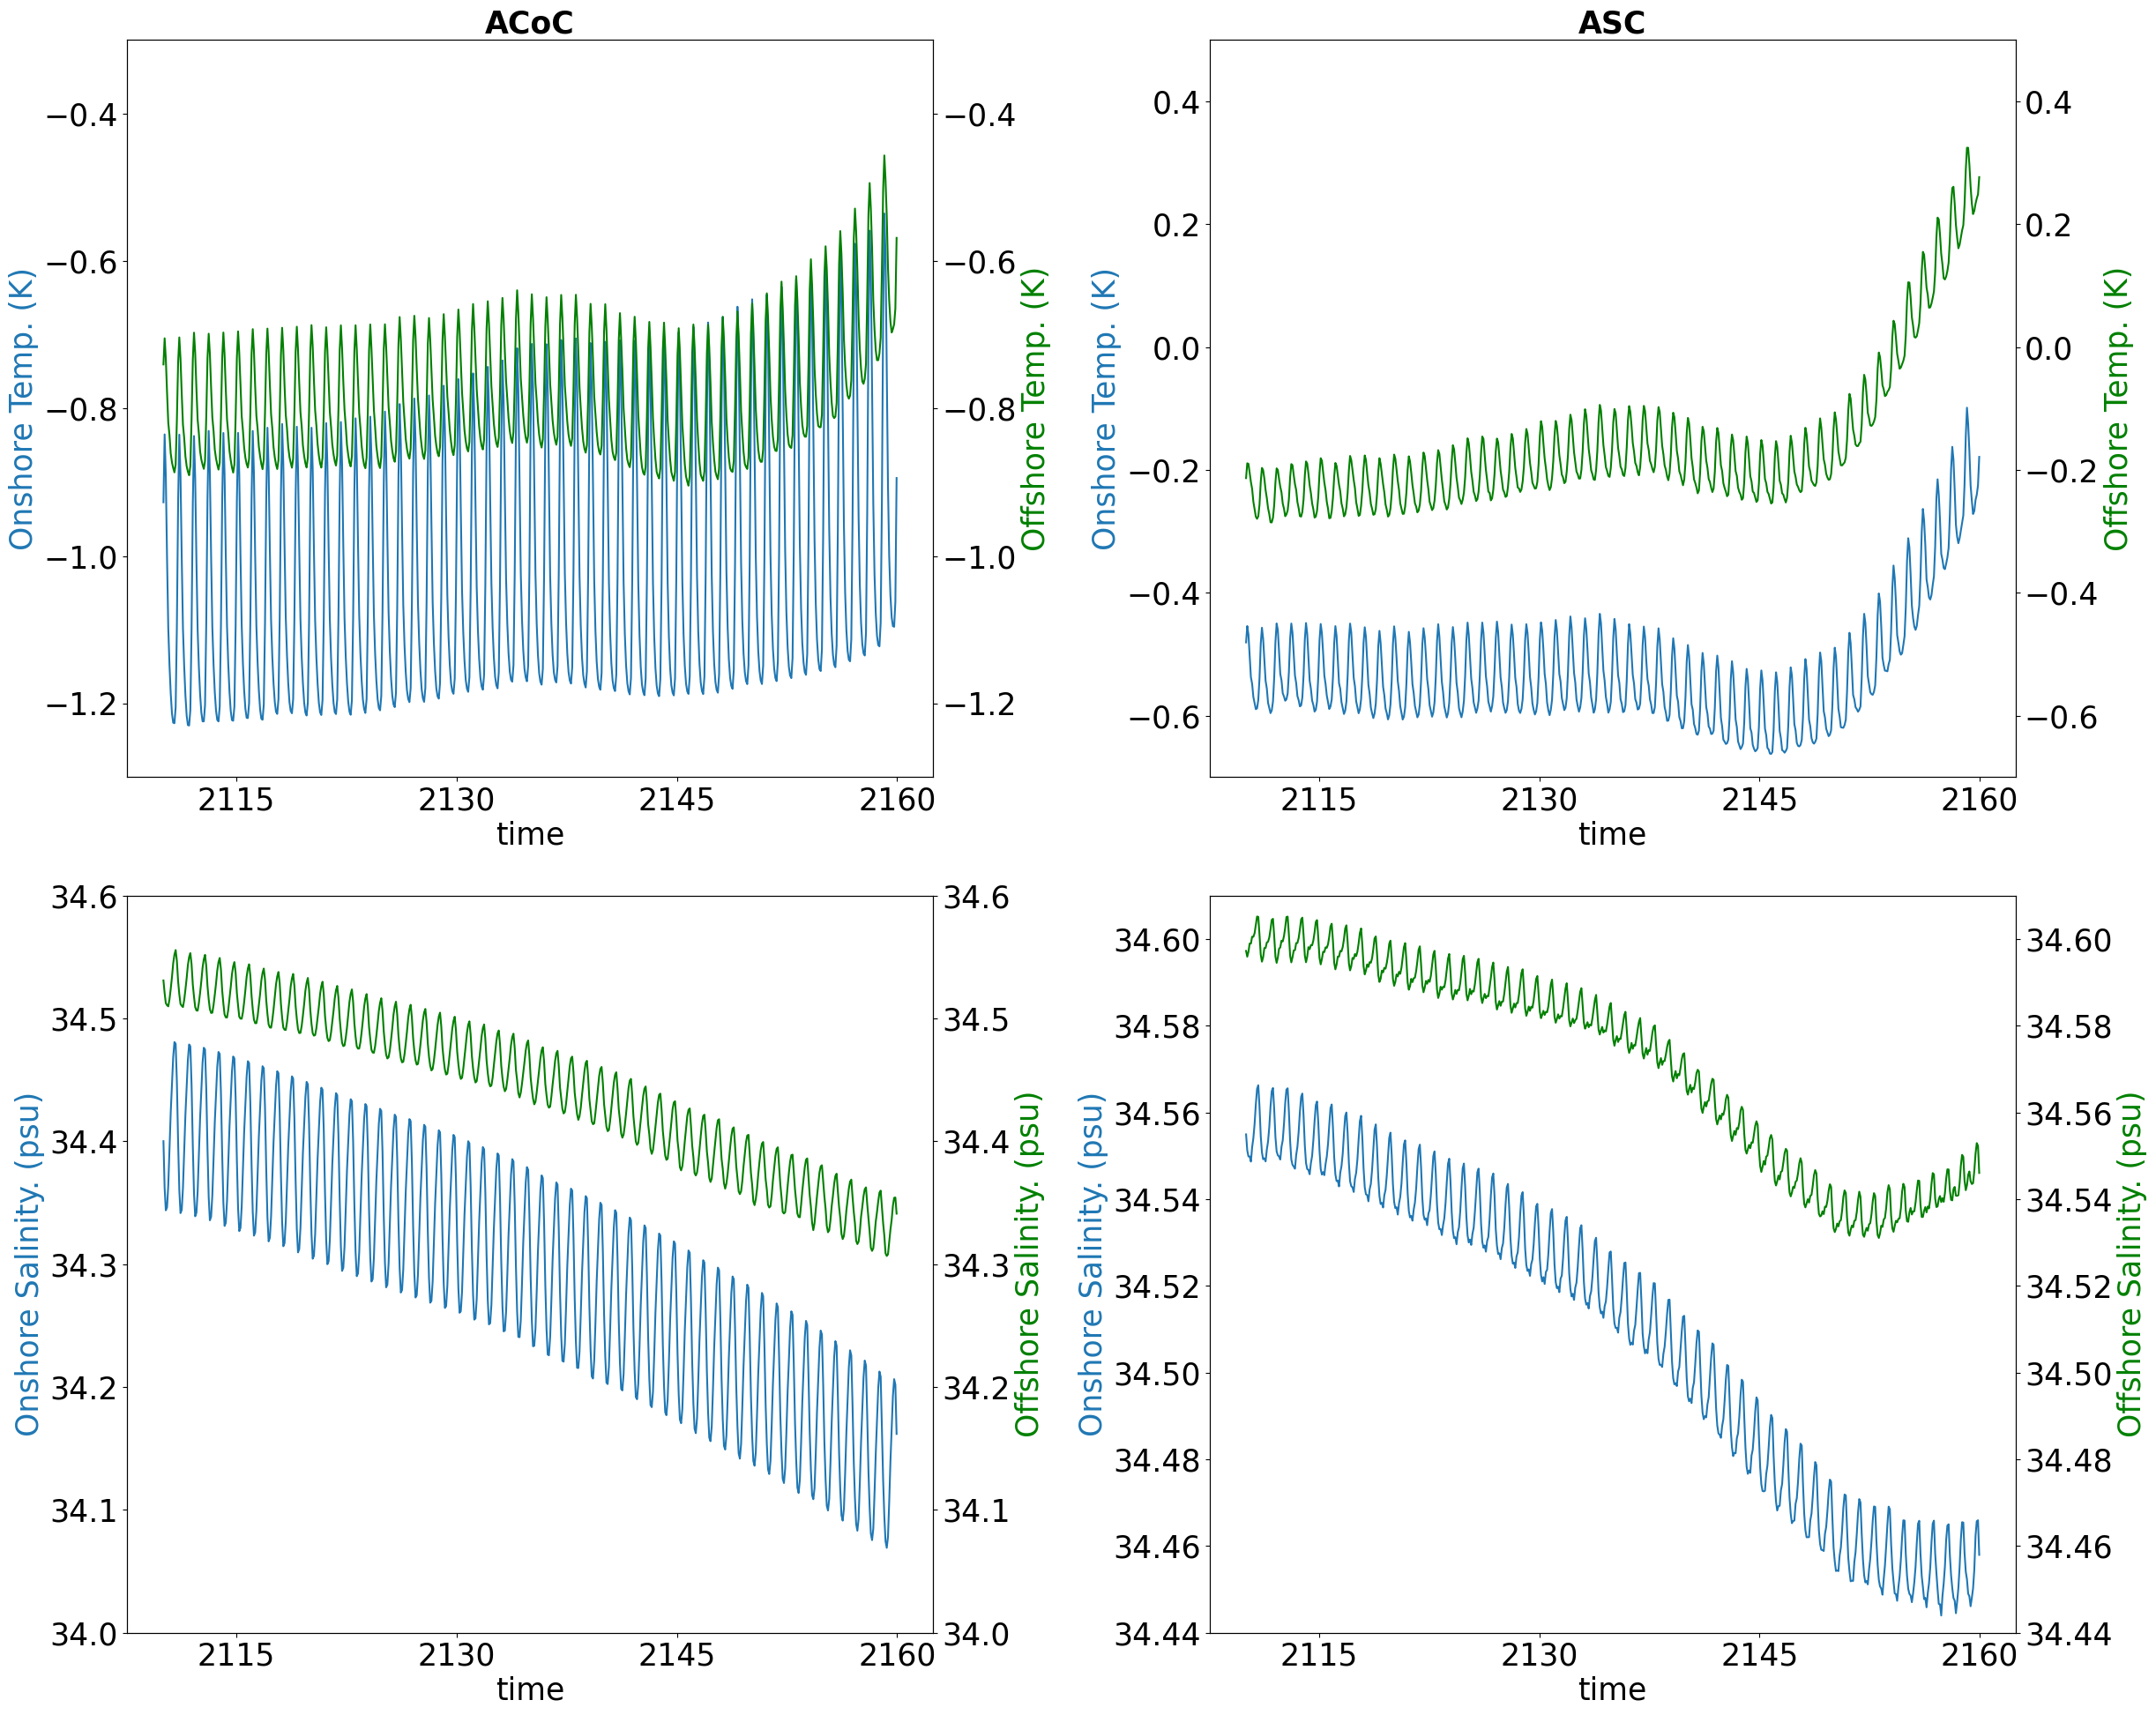

In [32]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25,20))
(temp_0_500_scaled.temp - 273).plot(ax = ax[0,0])
ax2 = ax[0,0].twinx()
(temp_500_1000_scaled.temp- 273).plot(c = 'g',ax = ax2)
ax[0,0].set_title('ACoC', weight = 'bold')

ax[0,0].set_ylim([-1.3,-0.3])
ax[0,0].set_ylabel('Onshore Temp. (K)',c = 'C0')
ax2.set_ylim([-1.3,-0.3])
ax2.set_ylabel('Offshore Temp. (K)',c = 'g')

(temp_1000_1500_scaled.temp- 273).plot(ax = ax[0,1])
ax2 = ax[0,1].twinx()
(temp_1500_2000_scaled.temp- 273).plot(c = 'g',ax = ax2)
ax[0,1].set_title('ASC', weight = 'bold')

ax[0,1].set_ylim([-0.7,0.5])
ax[0,1].set_ylabel('Onshore Temp. (K)',c = 'C0')
ax2.set_ylim([-0.7,0.5])
ax2.set_ylabel('Offshore Temp. (K)',c = 'g')
                  
salt_0_500_scaled.salt.plot(ax = ax[1,0])
ax2 = ax[1,0].twinx()
salt_500_1000_scaled.salt.plot(c = 'g',ax = ax2)
ax[1,0].set_ylim([34,34.6])
ax[1,0].set_ylabel('Onshore Salinity. (psu)',c = 'C0')
ax2.set_ylim([34.,34.6])
ax2.set_ylabel('Offshore Salinity. (psu)',c = 'g')

salt_1000_1500_scaled.salt.plot(ax = ax[1,1])
ax2 = ax[1,1].twinx()
salt_1500_2000_scaled.salt.plot(c = 'g',ax = ax2)

ax[1,1].set_ylim([34.44,34.61])
ax[1,1].set_ylabel('Onshore Salinity. (psu)',c = 'C0')
ax2.set_ylim([34.44,34.61])
ax2.set_ylabel('Offshore Salinity. (psu)',c = 'g')

plt.tight_layout()

In [50]:
temp_0_500_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_0_500_scaled.nc')
temp_500_1000_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_500_1000_scaled.nc')
temp_1000_1500_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_1000_1500_scaled.nc')
temp_1500_2000_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_1500_2000_scaled.nc')

salt_0_500_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_0_500_scaled.nc')
salt_500_1000_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_500_1000_scaled.nc')
salt_1000_1500_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_1000_1500_scaled.nc')
salt_1500_2000_scaled.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_1500_2000_scaled.nc')


In [33]:
diff_temp_ASC_t = temp_1000_1500_scaled - temp_1500_2000_scaled
diff_temp_ACoC_t= temp_0_500_scaled - temp_500_1000_scaled
diff_salt_ASC_t= salt_1000_1500_scaled - salt_1500_2000_scaled
diff_salt_ACoC_t= salt_0_500_scaled - salt_500_1000_scaled

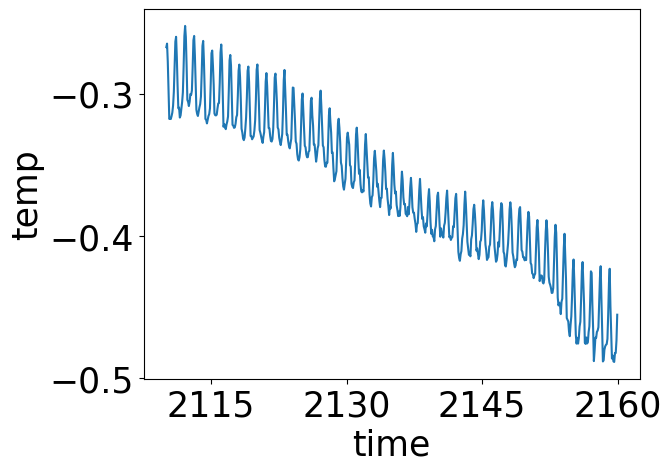

In [34]:
diff_temp_ASC_t.temp.plot()

In [54]:
diff_temp_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ASC_t_scaled.nc')
diff_temp_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_ACoC_t_scaled.nc')
diff_salt_ASC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ASC_t_scaled.nc')
diff_salt_ACoC_t.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_ACoC_t_scaled.nc')

In [91]:
ax2.get_yticks()

array([-1.1, -1. , -0.9, -0.8, -0.7, -0.6])

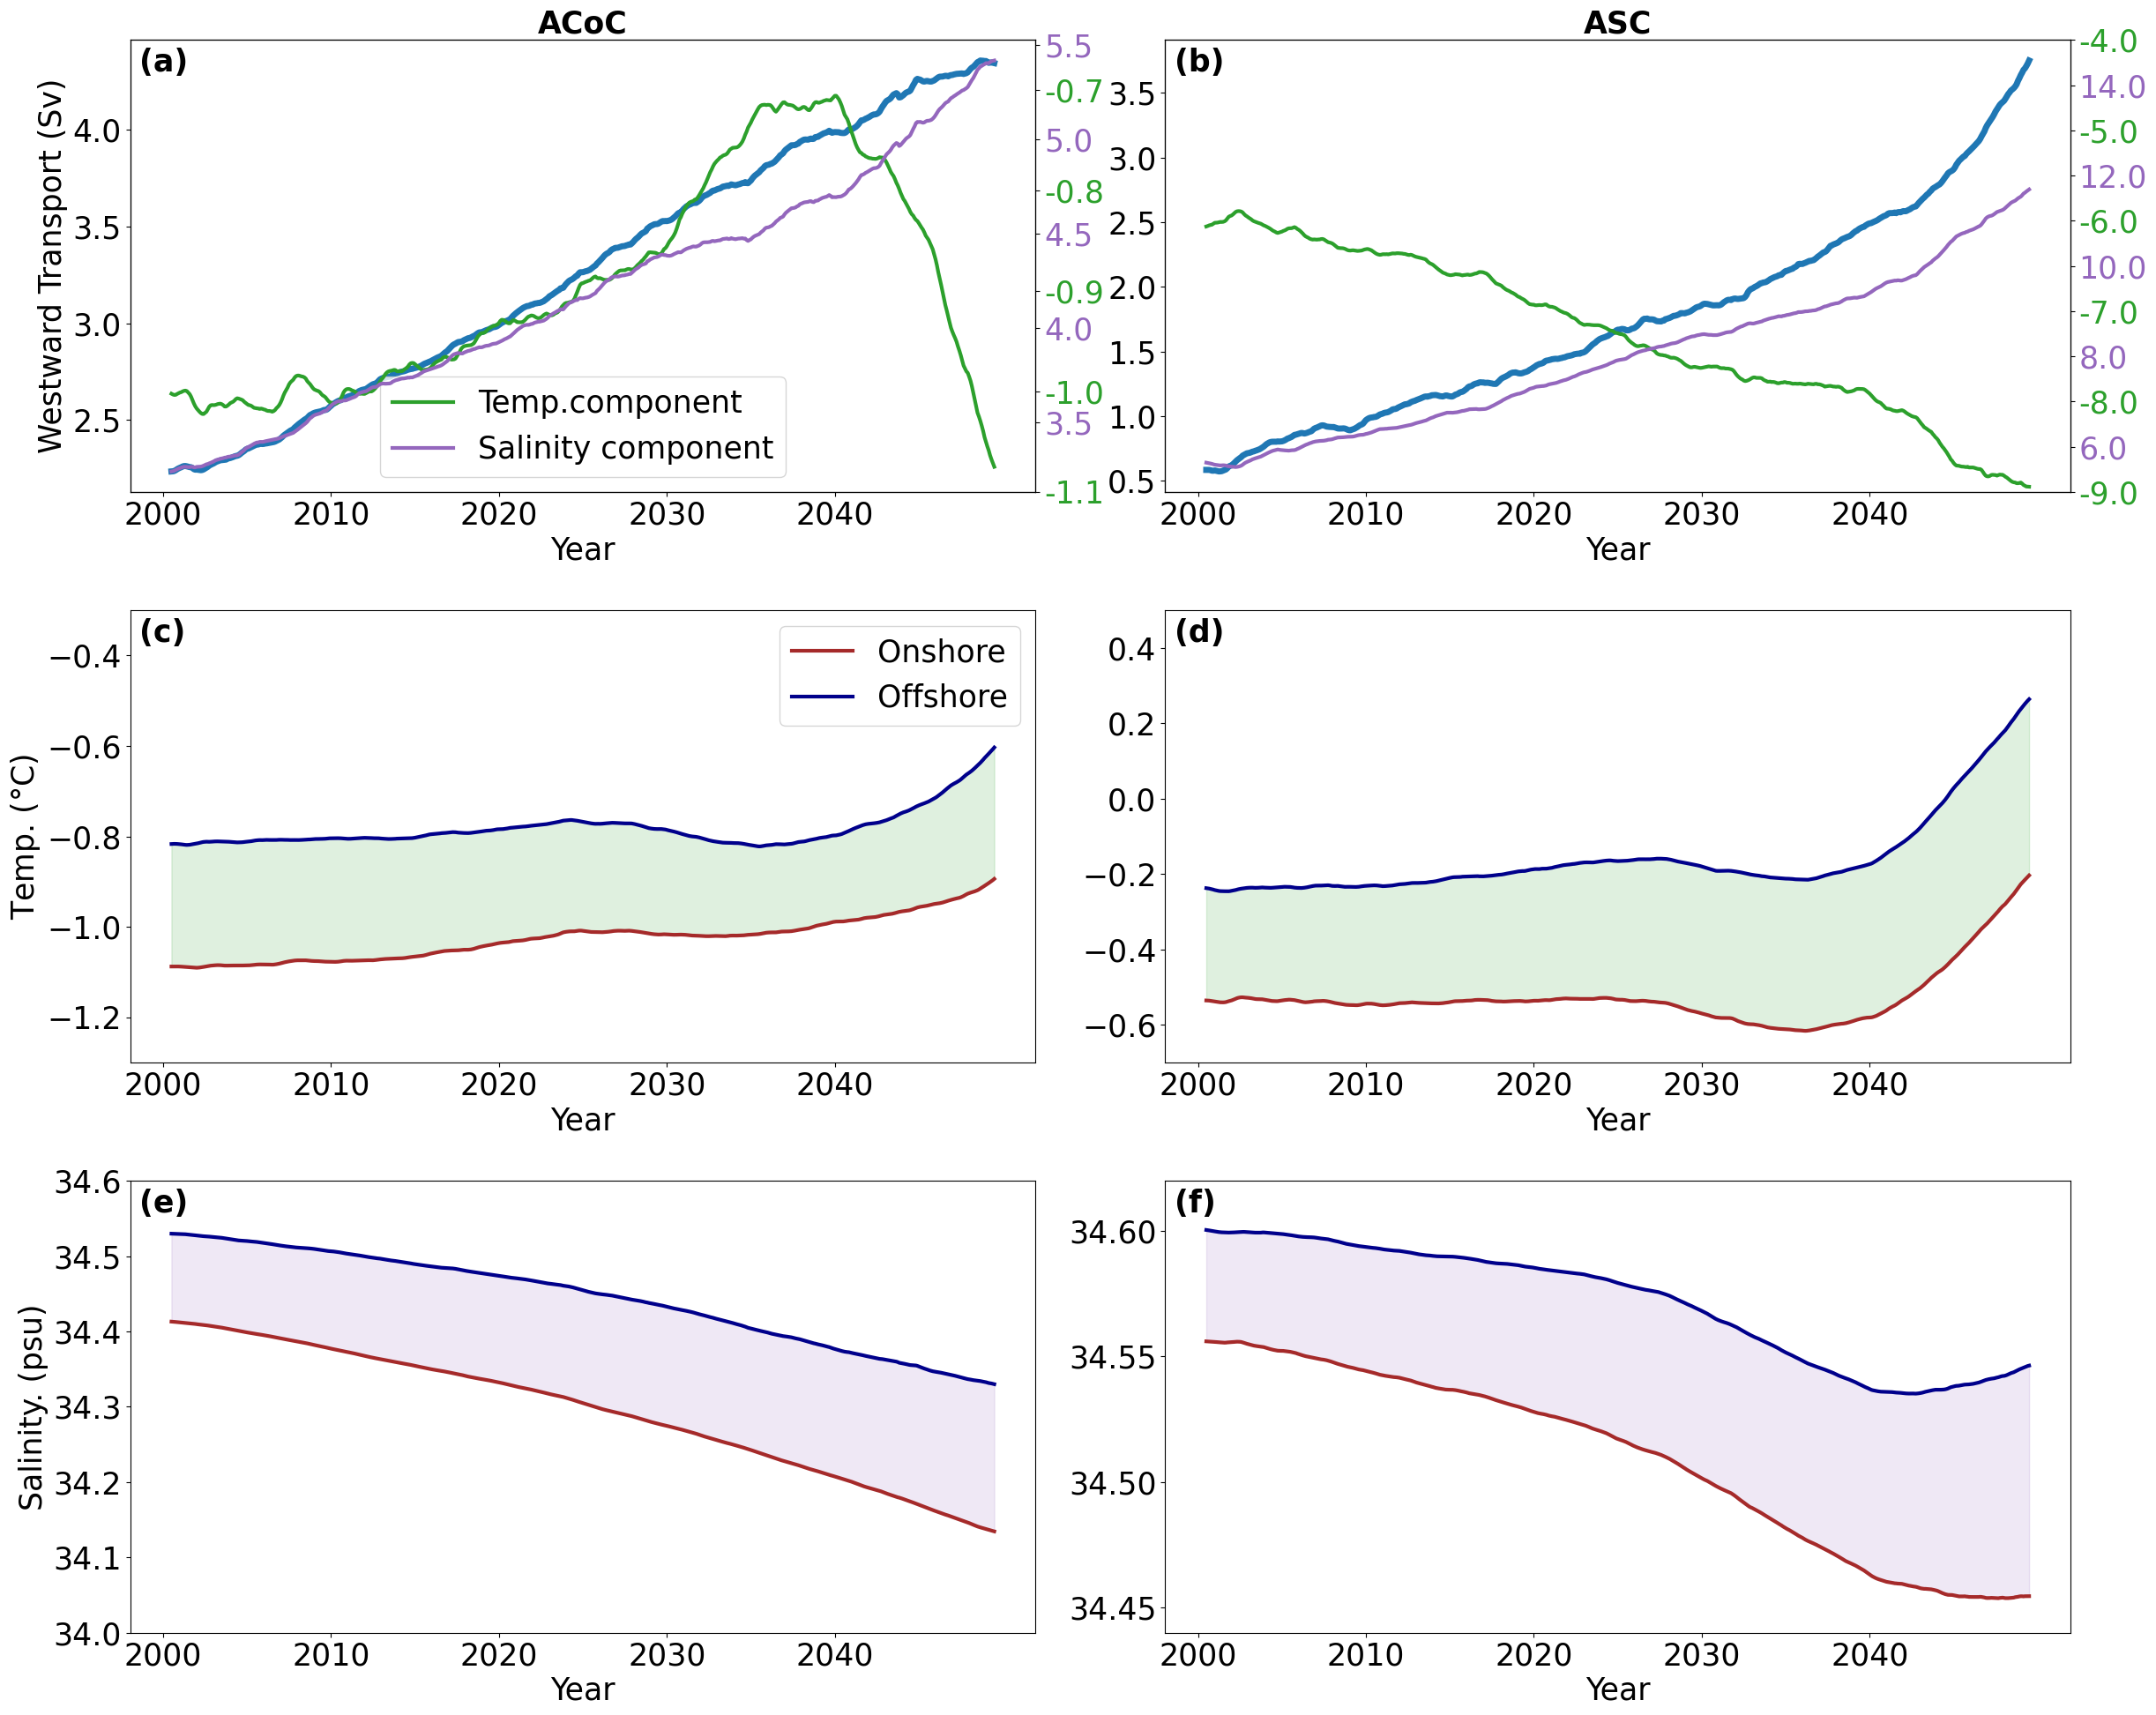

In [76]:
## master plot
lw = 3
#np.set_printoptions(precision=3)
from matplotlib.ticker import FormatStrFormatter

fig,ax = fig, ax = plt.subplot_mosaic("ab;cd;ef", figsize = (25,20))

(-T_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot(ax = ax['a'], label = 'ACoC depth-av', color = 'C0', lw = 5)
ax2 = ax['a'].twinx()
ax2.spines['right']
(-temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax2, lw = lw, label = 'Temp.component')
ax2.set_ylim([-1.1,-0.65])
ax2.set_yticklabels(labels = ax2.get_yticks(), color = 'C2')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_ylabel('')

ax3 = ax['a'].twinx()
(-salt_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax3, lw = lw, label = 'Salinity component')
ax3.set_yticklabels(labels = ax3.get_yticks(), color = 'C4')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.set_ylabel('', color= 'C4')
ax['a'].set_ylabel('Westward Transport (Sv)')

### Do everything for plot4 as before
handles4,labels4 = ax2.get_legend_handles_labels()
### Do everything for plot4a
handles4a,labels4a = ax3.get_legend_handles_labels()
### Combine the legend handles and labels to make a new legend object
handles = handles4 + handles4a
labels = labels4 + labels4a


(-T_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( label = 'ASC depth-av', ax = ax['b'], lw = 5)
ax2 = ax['b'].twinx()
(-temp_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax2, lw = lw)
ax2.set_yticklabels(labels = ax2.get_yticks(), color = 'C2')
ax2.set_ylabel('')

ax3 = ax['b'].twinx()
#ax3.spines['right'].set_position(('outward', 120))
(-salt_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax3, lw = lw)
ax2.set_ylim([-8,-3])
ax3.set_ylim([5,15])
ax3.set_yticklabels(labels = ax3.get_yticks(), color = 'C4')
ax3.set_ylabel('', color= 'C4')
ax['b'].set_ylabel('')


onshore_offshore_clr = ['brown', 'darkblue']
(temp_0_500_scaled.temp - 273).rolling(time = 12, center = True).mean().plot(label = 'Onshore',\
                                    color = onshore_offshore_clr[0], ax = ax['c'], lw = lw)
(temp_500_1000_scaled.temp- 273).rolling(time = 12, center = True).mean().plot( label = 'Offshore', \
                                      color = onshore_offshore_clr[1], ax = ax['c'], lw = lw)
ax['c'].fill_between(salt_0_500_scaled.time.values, \
                     (temp_0_500_scaled.temp- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_500_1000_scaled.temp- 273).rolling(time = 12, center = True).mean().values, \
                     alpha = 0.15, color = 'C2')
ax['a'].set_title('ACoC', weight = 'bold')
ax['c'].set_ylim([-1.3,-0.3])
ax['c'].set_ylabel(r'Temp. ($\degree$C)')
ax['c'].legend()

(temp_1000_1500_scaled.temp- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[0], ax = ax['d'], lw = lw)
(temp_1500_2000_scaled.temp- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1],ax = ax['d'], lw = lw)
ax['d'].fill_between(salt_0_500_scaled.time.values, \
                     (temp_1000_1500_scaled.temp- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_1500_2000_scaled.temp- 273).rolling(time = 12, center = True).mean().values,\
                     alpha = 0.15, color = 'C2')
ax['b'].set_title('ASC', weight = 'bold')

ax['d'].set_ylim([-0.7,0.5])
ax['d'].set_ylabel('')
  
salt_0_500_scaled.salt.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[0],ax = ax['e'], lw = lw)
salt_500_1000_scaled.salt.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[1],ax = ax['e'], lw = lw)
ax['e'].fill_between(salt_0_500_scaled.time.values, salt_0_500_scaled.salt.rolling(time = 12, center = True).mean().values,\
                     salt_500_1000_scaled.salt.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['e'].set_ylim([34,34.6])
ax['e'].set_ylabel('Salinity. (psu)')

salt_1000_1500_scaled.salt.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[0],ax = ax['f'], lw = lw)
salt_1500_2000_scaled.salt.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1], ax = ax['f'], lw = lw)
ax['f'].fill_between(salt_1500_2000_scaled.time.values, \
                     salt_1500_2000_scaled.salt.rolling(time = 12, center = True).mean().values,\
                     salt_1000_1500_scaled.salt.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['f'].set_ylim([34.44,34.62])
ax['f'].set_ylabel('')


for letter in list(map(chr, range(ord('a'), ord('f')+1))):
        ax[letter].set_xticks(salt_1000_1500_scaled.time[::120].values)
        ax[letter].set_xticklabels(np.arange(2000,2050,10))
        ax[letter].set_xlabel('Year')
        ax[letter].text(0.01,0.93,'(' + letter + ')', \
                        transform=ax[letter].transAxes, fontweight = 'bold')
ax['a'].legend(handles, labels, loc = 'lower center')

'''
ax['a'].set_xticks(salt_1000_1500_scaled.time[::120].values)
ax['a'].set_xticklabels(np.arange(2000,2050,10))
ax['a'].set_xlabel('Year')
'''

plt.tight_layout()

In [56]:
import cftime

In [62]:
salt_1000_1500_scaled.time[::120].values

array([cftime.DatetimeNoLeap(2110, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2120, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2130, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2140, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2150, 1, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)